In [5]:
#pip install QuantStats

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import math
import time
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import matplotlib.ticker as ticker
import quantstats as qs
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# PCA_10 dataset

## Dataset Preparation for Analysis

In [9]:
PCA_5 = pd.read_csv('/content/drive/MyDrive/Optimas Code/final_df_10new2.csv')

In [10]:
PCA_5.head(1)

date     ticker  market_share_PCA_1  market_share_PCA_2  \
0  2008-01-31  000767-CN           -1.685366            0.230391   

   market_share_PCA_3  market_share_PCA_4  market_share_PCA_5  \
0            1.334093           -2.817511           -5.900945   

   market_share_PCA_6  market_share_PCA_7  market_share_PCA_8  ...  \
0            -0.60148            -0.33562            0.667796  ...   

    board_PCA_2   board_PCA_3   board_PCA_4   board_PCA_5  market_index_PCA_1  \
0  6.001703e-13 -1.357760e-12  6.848555e-13  4.793433e-13            0.957957   

   market_index_PCA_2  market_index_PCA_3  market_index_PCA_4  \
0            4.291295            0.038248           -0.225657   

   market_index_PCA_5  next_month_return  
0           -2.082732           0.121975  

[1 rows x 486 columns]

In [11]:
PCA_5.shape

(122998, 486)

In [12]:
# Dataframe for Backtesting Strategy

PCA_5_backtest = PCA_5.copy()

In [13]:
PCA_5_backtest['date'] = pd.to_datetime(PCA_5_backtest['date'])
PCA_5_backtest.set_index(['date','ticker'], inplace=True)

## Filter Relevant Features Using IC Scores

In [ ]:
def cal_ICs(df, factor_list, col_re, startdate=None, enddate=None):
    """
    :param df: time-series dataframe with factors and return
    :param factor_list: factor list in dataframe
    :param col_re: column of reutrn in dataframe
    :param startdate: start date of IC calculation
    :param enddate: end date of IC calculation

    :return: time-series dataframe of IC score
    """
    IC_dfs_ = []
    for f in factor_list:
        IC = []

        factor = df[[f]].unstack(level=1)
        re_future = df[[col_re]].unstack(level=1)

        if startdate==None or enddate==None:

            datelist = re_future.loc[startdate:enddate].index.tolist()
            factor_arr = factor.values
            re_future_arr = re_future.values

        else:
            factor = factor.loc[startdate:enddate]
            datelist = re_future.loc[startdate:enddate].index.tolist()

            factor_arr = factor.values
            re_future_arr = re_future.loc[startdate:enddate].values

        dt_ind = []
        if factor.shape[0]==len(datelist):
            for dt in range(len(datelist)):
                x = factor_arr[dt]
                re = re_future_arr[dt]
                if np.sum(np.logical_and(~np.isnan(x),~np.isnan(re)))>200:
                    dt_ind.append(dt)
                    ind=np.where(np.logical_and(~np.isnan(x),~np.isnan(re)))[0]
                    x = x[ind]
                    re = re[ind]
                    IC.append(stats.spearmanr(x, re, nan_policy='omit')[0])
        IC_df = pd.Series(index=datelist)
        IC_df[np.array(datelist)[dt_ind]] = IC
        IC_df.name = f
        IC_dfs_.append(IC_df)

    IC_dfs = pd.DataFrame(IC_dfs_)
    return IC_dfs.T

In [ ]:
#input_columns = PCA_5_backtest.loc[:,'market_share_PCA_1':'market_index_PCA_5'].columns.tolist()
factor_list_pca10 = PCA_5_backtest.columns[PCA_5_backtest.columns!='next_month_return'].tolist()


In [14]:
%%time

IC_all = cal_ICs(df=PCA_5_backtest, factor_list=factor_list_pca10, col_re='next_month_return', startdate='2008-01-01', enddate='2022-11-30')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [ ]:
IC_all

market_share_PCA_1  market_share_PCA_2  market_share_PCA_3  \
2008-01-31           -0.028805            0.030288            0.076513   
2008-02-29           -0.012589            0.004880           -0.078520   
2008-03-31            0.110134            0.029976           -0.052455   
2008-04-30            0.053316            0.114062            0.114282   
2008-05-30           -0.000789            0.138117            0.123029   
...                        ...                 ...                 ...   
2022-07-29           -0.003402            0.006539            0.012869   
2022-08-31            0.068433           -0.139259           -0.176425   
2022-09-30           -0.168133            0.114007            0.084779   
2022-10-31            0.144770           -0.213252           -0.155901   
2022-11-30            0.052249            0.023598            0.069080   

            market_share_PCA_4  market_share_PCA_5  market_share_PCA_6  \
2008-01-31           -0.138949            0.001575            0.032208   
2008-02-29            0.159682            0.037807           -0.071857   
2008-03-31            0.077322           -0.057233            0.046569   
2008-04-30           -0.066164           -0.039006            0.073128   
2008-05-30            0.172818           -0.067473            0.010651   
...                        ...                 ...                 ...   
2022-07-29            0.026919           -0.058159            0.091622   
2022-08-31            0.144352           -0.026606            0.051871   
2022-09-30            0.003628           -0.053763            0.074315   
2022-10-31            0.061893            0.083238           -0.092744   
2022-11-30            0.103149           -0.043264           -0.085833   

            market_share_PCA_7  market_share_PCA_8  market_share_PCA_9  \
2008-01-31           -0.044693            0.108869           -0.048519   
2008-02-29           -0.035161           -0.144064            0.036110   
2008-03-31            0.038434           -0.013684            0.158908   
2008-04-30           -0.079093            0.051940           -0.072381   
2008-05-30            0.059124           -0.120058            0.119464   
...                        ...                 ...                 ...   
2022-07-29           -0.002141           -0.025795           -0.007287   
2022-08-31            0.072422           -0.067063           -0.039425   
2022-09-30           -0.053401           -0.008269            0.093543   
2022-10-31            0.114212           -0.037408           -0.079846   
2022-11-30            0.050237           -0.086409            0.008091   

            market_share_PCA_10  ...  board_PCA_1  board_PCA_2  board_PCA_3  \
2008-01-31            -0.031575  ...    -0.012648     0.127813     0.001498   
2008-02-29            -0.023034  ...          NaN          NaN          NaN   
2008-03-31             0.082053  ...          NaN          NaN          NaN   
2008-04-30             0.074217  ...          NaN          NaN          NaN   
2008-05-30             0.128610  ...          NaN          NaN          NaN   
...                         ...  ...          ...          ...          ...   
2022-07-29             0.011304  ...     0.026644    -0.015552     0.037000   
2022-08-31             0.080624  ...     0.183996     0.040966     0.102755   
2022-09-30            -0.105565  ...    -0.151020    -0.064197    -0.081526   
2022-10-31             0.022938  ...     0.171522     0.057024     0.015875   
2022-11-30             0.096775  ...     0.027146     0.085032    -0.046623   

            board_PCA_4  board_PCA_5  market_index_PCA_1  market_index_PCA_2  \
2008-01-31    -0.032897    -0.029575           -0.037707            0.080151   
2008-02-29          NaN          NaN           -0.114992           -0.109020   
2008-03-31          NaN          NaN           -0.088109            0.052530   
2008-04-30          NaN          NaN            0.049297           -0.092019

In [ ]:
# Choose a Threshold To Filter Features
threshold = 0.05

# Calculate the mean of each column and filter columns
columns_above_threshold = np.abs(IC_all).mean() > threshold

# Select only those columns where the average is greater than the threshold
filtered_columns = IC_all.loc[:, columns_above_threshold]

print(filtered_columns)

            market_share_PCA_1  market_share_PCA_2  market_share_PCA_3  \
2008-01-31           -0.028805            0.030288            0.076513   
2008-02-29           -0.012589            0.004880           -0.078520   
2008-03-31            0.110134            0.029976           -0.052455   
2008-04-30            0.053316            0.114062            0.114282   
2008-05-30           -0.000789            0.138117            0.123029   
...                        ...                 ...                 ...   
2022-07-29           -0.003402            0.006539            0.012869   
2022-08-31            0.068433           -0.139259           -0.176425   
2022-09-30           -0.168133            0.114007            0.084779   
2022-10-31            0.144770           -0.213252           -0.155901   
2022-11-30            0.052249            0.023598            0.069080   

            market_share_PCA_4  market_share_PCA_5  market_share_PCA_6  \
2008-01-31           -0.138949       

In [ ]:
features = [col for col in filtered_columns.columns]

In [ ]:
df_m = PCA_5_backtest[features]

In [ ]:
df_m["next_month_return"] = PCA_5_backtest["next_month_return"]

<ipython-input-19-718c8c377556>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m["next_month_return"] = PCA_5_backtest["next_month_return"]


In [ ]:
df_m = df_m.reset_index()
df_m['date'] = pd.to_datetime(df_m['date'])
df_m.set_index(["date"], inplace=True)

In [ ]:
df_m.tail(2)

ticker  market_share_PCA_1  market_share_PCA_2  \
date                                                            
2022-12-30  002821-CN           -0.840430            0.875009   
2022-12-30  603858-CN            1.542298            2.026921   

            market_share_PCA_3  market_share_PCA_4  market_share_PCA_5  \
date                                                                     
2022-12-30           -0.367964           -0.936757           -0.426869   
2022-12-30           -0.592342            1.873809           -0.521278   

            market_share_PCA_6  market_share_PCA_7  market_share_PCA_8  \
date                                                                     
2022-12-30            0.465779           -0.003735           -0.040673   
2022-12-30            0.482291            0.366727            0.436891   

            market_share_PCA_9  ...  management_PCA_4  board_PCA_1  \
date                            ...                                  
2022-12-30           -0.172629  ...          6.054098    -3.129095   
2022-12-30            0.130990  ...          0.294400     5.169292   

            board_PCA_2  board_PCA_3  market_index_PCA_1  market_index_PCA_2  \
date                                                                           
2022-12-30    -0.382653    -5.594290            1.846457            1.401060   
2022-12-30     1.124840    -2.001622            2.549149            0.943262   

            market_index_PCA_3  market_index_PCA_4  market_index_PCA_5  \
date                                                                     
2022-12-30            0.026019            1.644092            0.891276   
2022-12-30           -0.055764           -3.212554           -3.379238   

            next_month_return  
date                           
2022-12-30                NaN  
2022-12-30                NaN  

[2 rows x 239 columns]

In [ ]:
df_m.to_csv('/content/drive/MyDrive/Optimas Code/df_m.csv')

## Backtesting ~ Random Forest with a Rolling Window

In [ ]:
def datelist(beginDate, endDate):
    # beginDate, endDate: ‘20160601’, string or datetime
    date_l=[datetime.strftime(x,'%Y-%m') for x in list(pd.date_range(start=beginDate, end=endDate,freq = 'M'))]
    return date_l
d_len_bt = datelist("2008-01-01","2022-11-30")

In [ ]:
def randomforest(data,d_len,window_size,step,test_size,estimator,depth,s,l):
    """
    :param data: time-series dataframe with factors and return
    :param d_len: year-month data for the train and test
    :param window_size: xgboost training window size
    :param step: test step
    :param max_depth: xgboost model params
    :param learning_rate: xgboost model params
    :param num_round: xgboost model params

    :return: time-series dataframe of predicted return
    """
    predictions = pd.DataFrame({"date":[],"ticker":[],"next_month_return":[],"pred_return":[]})
    overfit = 0
    for i in range(0, len(d_len) - window_size-1, step):
        # set window
        window_start = d_len[i]
        window_end = d_len[i + window_size-1]

        # Splitting Windows
        window = data[window_start:window_end]
        window = window.set_index("ticker")

        # split features and target
        X = window.drop(['next_month_return'], axis=1).fillna(0)  # Features
        y = window['next_month_return'].fillna(0)

        model = RandomForestRegressor(n_estimators = estimator, max_depth = depth, min_samples_split = s , min_samples_leaf = l )
        model.fit(X,y)


        # Predict the next 12 month's stocks next_month_return
        '''''
        window_end_plus_1 = d_len[i + window_size]
        if i+window_size+test_size<len(d_len):
            window_end_plus_test_size = d_len[i+window_size+test_size]
        else:
            window_end_plus_test_size = d_len[-1]

        next_window = data[window_end_plus_1:window_end_plus_test_size]  # Data for test and predict
        '''
        # Predict the next month's stocks next_month_return
        window_end_plus_1 = d_len[i + window_size+1]
        next_window = data.loc[window_end_plus_1]
        next_window = next_window.set_index("ticker")
        #next_window = next_window.set_index("ticker")

        X_next = next_window.drop(['next_month_return'], axis=1).fillna(0)
        #X_next = next_window.drop(['next_month_return','ticker'], axis=1).fillna(0)

        y_test = next_window['next_month_return'].fillna(0)    # test

        y_pred = model.predict(X_next)
        # mse_test = mean_squared_error(y_test, y_pred)

        pred = pd.DataFrame({"date":[],"ticker":[],"next_month_return":[],"pred_return":[]})
        next_window = next_window.reset_index()
        '''''
        pred["next_month_return_"] = next_window["next_month_return"]
        pred["pred_return"] = y_pred
        pred["ticker"] = next_window["ticker"]
        pred["date"] = next_window.index
        '''
        pred["next_month_return"] = next_window["next_month_return"]
        pred["pred_return"] = y_pred
        pred["date"] = window_end_plus_1
        pred["ticker"] = next_window['ticker']

        #predictions = predictions.merge(pred,how="outer")
        predictions = pd.concat([predictions, pred], ignore_index=True)
    # print(overfit)
    return predictions

In [ ]:
# Window size = 12
predictions_12 = randomforest(df_m,d_len_bt,12,1,12,100,3,5,2)

#data,d_len,window_size,step,test_size,estimator,depth,s,l

In [ ]:
predictions_12

date     ticker  next_month_return  pred_return
0       2009-02  000767-CN           0.195719    -0.010007
1       2009-02  600058-CN           0.164961    -0.000954
2       2009-02  000800-CN           0.225774    -0.001938
3       2009-02  600085-CN           0.110264    -0.020565
4       2009-02  600089-CN           0.206358    -0.086197
...         ...        ...                ...          ...
118293  2022-11  600909-CN          -0.068966    -0.012781
118294  2022-11  002920-CN          -0.042277    -0.011112
118295  2022-11  002812-CN           0.055216    -0.020233
118296  2022-11  002821-CN           0.103160    -0.028193
118297  2022-11  603858-CN          -0.072406    -0.013098

[118298 rows x 4 columns]

In [ ]:
predictions_12.to_csv('/content/drive/MyDrive/Optimas Code/PCA10_predictions_ic05.csv')

### Store monthly returns predicted by the model (window size = 12)

In [ ]:
predictions_12.to_csv('PCA5_prediction_w12')

# Import Predictions

In [15]:
predictions_12= pd.read_csv('/content/drive/MyDrive/Optimas Code/PCA10_predictions_ic05.csv')

## Cumulative Returns~ Split Stocks into 5 Layers

In [16]:
# Window size = 12
predictions_12['date'] = pd.to_datetime(predictions_12['date'])

# Group the data by month
predictions_12['year_month'] = predictions_12['date'].dt.to_period('M')
grouped_data_12 = predictions_12.groupby('year_month')

In [17]:
# Initialize an empty DataFrame to store cumulative returns for each decile
store_returns_12_avg = pd.DataFrame(index=predictions_12['year_month'].unique(), columns=range(1, 6))

In [18]:
# Take average of all stocks in each layer
for month, group in grouped_data_12:
    # Sort the group by predicted returns (decending)
    group_sorted = group.sort_values(by='pred_return',ascending=False)

    # Calculate number of stocks in each decile
    num_stocks = len(group_sorted)
    stocks_per_decile = num_stocks // 5

    # Initialize an empty DataFrame to store average actual returns for each decile
    avg_actual_returns = pd.DataFrame(index=range(1, 6), columns=['avg_actual_return'])

    # Loop through each decile
    for decile in range(1, 6):
        # Calculate the start and end indices for the current decile
        start_idx = (decile - 1) * stocks_per_decile
        end_idx = decile * stocks_per_decile

        # Calculate average actual return for the current decile using the top 20 stocks
        avg_actual_return = group_sorted['next_month_return'][start_idx:end_idx].mean()
        store_returns_12_avg.loc[month,decile] = avg_actual_return

In [19]:
## df containing the 5 layers
store_returns_12_avg

1         2         3         4         5
2009-02     0.255  0.224792  0.204352  0.179003  0.155922
2009-03  0.079436  0.058059  0.038687  0.046519   0.01995
2009-04  0.084651  0.061338  0.059024  0.072943  0.000435
2009-05  0.096622  0.081351  0.083001  0.132061  0.077694
2009-06  0.244528  0.205674  0.185405  0.161697  0.130172
...           ...       ...       ...       ...       ...
2022-07 -0.019717 -0.016116 -0.023972  0.002556  -0.02149
2022-08 -0.076005 -0.077336 -0.073583 -0.069029 -0.063266
2022-09  0.010011   0.00032  0.006246  0.012009 -0.013208
2022-10  0.107459  0.071522  0.088099  0.104053  0.053432
2022-11 -0.027791 -0.034072   -0.0381 -0.026061 -0.013673

[166 rows x 5 columns]

### Top 20 stocks per layer

In [20]:
store_returns_12_t20 = pd.DataFrame(index=predictions_12['year_month'].unique(), columns=range(1, 6))

In [21]:
# Take top 20 stocks in each layer
for month, group in grouped_data_12:
    # Sort the group by predicted returns (decending)
    group_sorted = group.sort_values(by='pred_return',ascending=False)

    # Calculate number of stocks in each decile
    num_stocks = len(group_sorted)
    stocks_per_decile = num_stocks // 5

    # Initialize an empty DataFrame to store average actual returns for each decile
    avg_actual_returns = pd.DataFrame(index=range(1, 6), columns=['avg_actual_return'])

    # Loop through each decile
    for decile in range(1, 6):
        # Calculate the start and end indices for the current decile
        start_idx = (decile - 1) * stocks_per_decile
        end_idx = decile * stocks_per_decile

        # Select only the top 20 stocks within the current decile
        decile_top_20 = group_sorted.iloc[start_idx:end_idx]
        if len(decile_top_20) > 20:
            decile_top_20 = decile_top_20.head(20)

        # Calculate average actual return for the current decile using the top 20 stocks
        avg_actual_return = decile_top_20['next_month_return'].mean()
        store_returns_12_t20.loc[month,decile] = avg_actual_return

In [22]:
store_returns_12_t20

1         2         3         4         5
2009-02  0.272627  0.261581   0.19907  0.200782  0.164455
2009-03  0.164387  0.058681 -0.001554  0.037128    0.0168
2009-04  0.106722   0.04861  0.044073  0.097082  0.019255
2009-05   0.09187  0.107544  0.069954  0.159063  0.083605
2009-06  0.313393  0.240065  0.150204  0.168157  0.111174
...           ...       ...       ...       ...       ...
2022-07 -0.043745 -0.024301 -0.045446  0.009377 -0.011336
2022-08 -0.079262 -0.087275 -0.077626   -0.0844 -0.073143
2022-09  0.022189  0.004146  -0.02453  0.044077  0.023523
2022-10  0.050376  0.082996    0.0826  0.115535  0.118391
2022-11 -0.026416 -0.025487 -0.058892 -0.027214 -0.035102

[166 rows x 5 columns]

### Bottom 20 stocks of each layer

In [23]:
store_returns_12_b20 = pd.DataFrame(index=predictions_12['year_month'].unique(), columns=range(1, 6))

In [24]:
# Take bottom 20 stocks in each layer
for month, group in grouped_data_12:
    # Sort the group by predicted returns (decending)
    group_sorted = group.sort_values(by='pred_return',ascending=False)

    # Calculate number of stocks in each decile
    num_stocks = len(group_sorted)
    stocks_per_decile = num_stocks // 5

    # Initialize an empty DataFrame to store average actual returns for each decile
    avg_actual_returns = pd.DataFrame(index=range(1, 6), columns=['avg_actual_return'])

    # Loop through each decile
    for decile in range(1, 6):
        # Calculate the start and end indices for the current decile
        start_idx = (decile - 1) * stocks_per_decile
        end_idx = decile * stocks_per_decile

        # Select only the top 20 stocks within the current decile
        decile_bottom_20 = group_sorted.iloc[start_idx:end_idx]
        if len(decile_bottom_20) > 20:
            decile_bottom_20 = decile_bottom_20.tail(20)

        # Calculate average actual return for the current decile using the bottom 20 stocks
        avg_actual_return = decile_bottom_20['next_month_return'].mean()
        store_returns_12_b20.loc[month,decile] = avg_actual_return

In [25]:
store_returns_12_b20

1         2         3         4         5
2009-02  0.222393  0.224129  0.231722  0.176485  0.143755
2009-03  0.028865  0.046397  0.067884  0.071327  0.016572
2009-04  0.051435   0.04206  0.034881  0.067417 -0.018091
2009-05  0.087883  0.092157  0.122923   0.13337  0.071824
2009-06  0.233911  0.177758  0.196186  0.121995    0.1477
...           ...       ...       ...       ...       ...
2022-07 -0.035576 -0.032317 -0.036511 -0.000136 -0.056024
2022-08 -0.103078 -0.061874 -0.067879 -0.072276 -0.079223
2022-09  0.016842  0.057608 -0.021261  0.027358 -0.069103
2022-10  0.103357  0.108195  0.081152   0.12122    -0.021
2022-11 -0.053236 -0.056316 -0.037456 -0.019972 -0.058058

[166 rows x 5 columns]

### Store Layered Returns (window size = 12)

In [26]:
# Cumulative Returns of Each Layer
cum_returns_12_avg = np.cumsum(store_returns_12_avg, axis=0)

# Convert index to string
cum_index_12_avg = cum_returns_12_avg.index.to_series().astype(str)

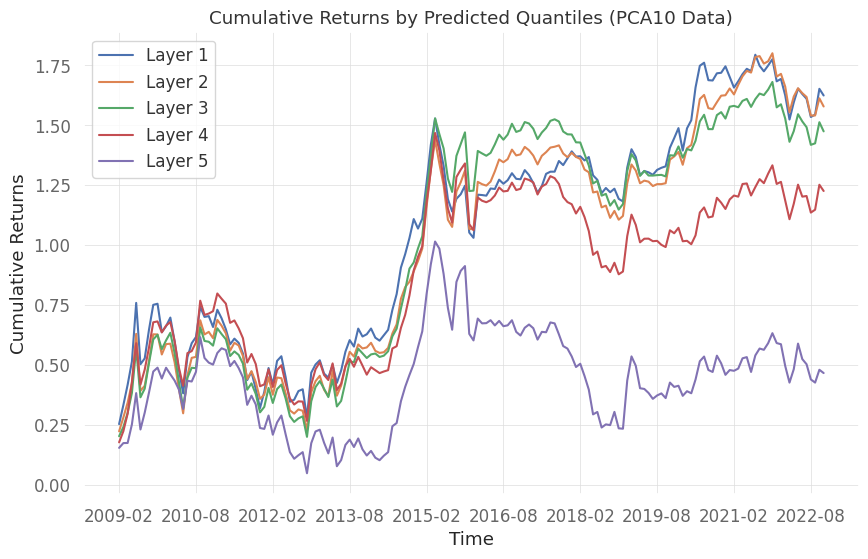

In [28]:
# Plot the cumulative returns for each percentile
plt.figure(figsize=(10, 6))
for decile in range(1, 6):
    plt.plot(cum_index_12_avg,cum_returns_12_avg[decile], label=f'Layer {decile}')

# Set date on x-axis
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(18))

plt.title('Cumulative Returns by Predicted Quantiles (PCA10 Data)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# QuantStats Report

[Performance Metrics]



                           Layer 1     Layer 2     Layer 3     Layer 4     Layer 5
-------------------------  ----------  ----------  ----------  ----------  ----------
Start Period               2009-02-28  2009-02-28  2009-02-28  2009-02-28  2009-02-28
End Period                 2022-11-30  2022-11-30  2022-11-30  2022-11-30  2022-11-30
Risk-Free Rate             0.0%        0.0%        0.0%        0.0%        0.0%
Time in Market             100.0%      100.0%      100.0%      100.0%      100.0%

Cumulative Return          223.09%     220.75%     197.66%     130.39%     10.9%
CAGR﹪                     6.06%       6.02%       5.62%       4.28%       0.52%

Sharpe                     0.46        0.47        0.45        0.37        0.15
Prob. Sharpe Ratio         95.67%      95.86%      95.36%      91.71%      70.77%
Smart Sharpe               0.42        0.43        0.42        0.34        0.14
Sortino                    0.73        0.75        0.72        0.59        0.22
Smart Sortin

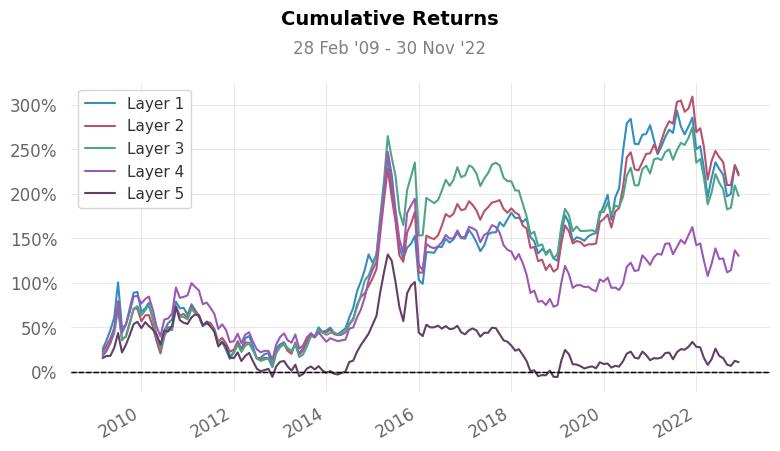

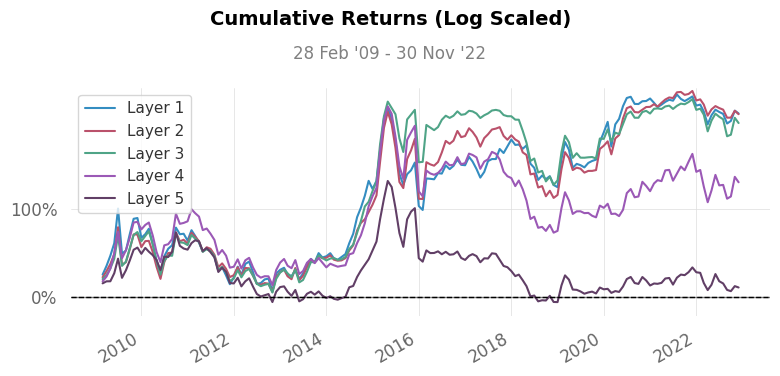

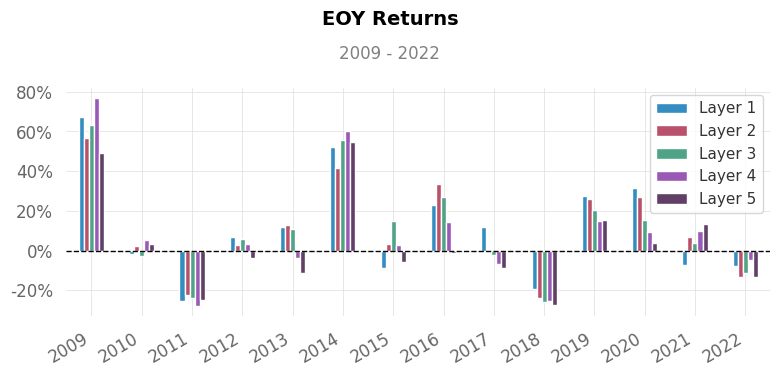

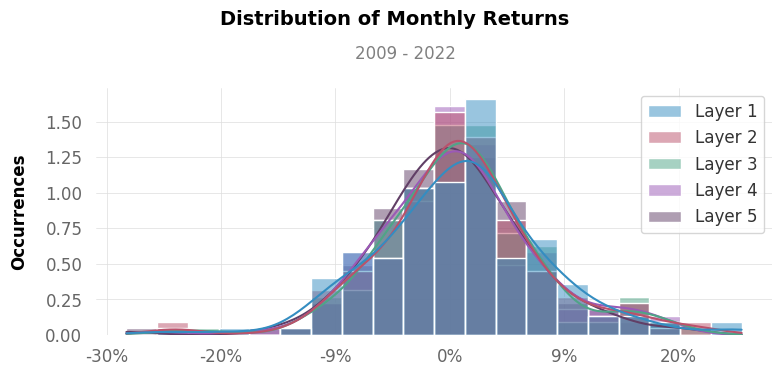

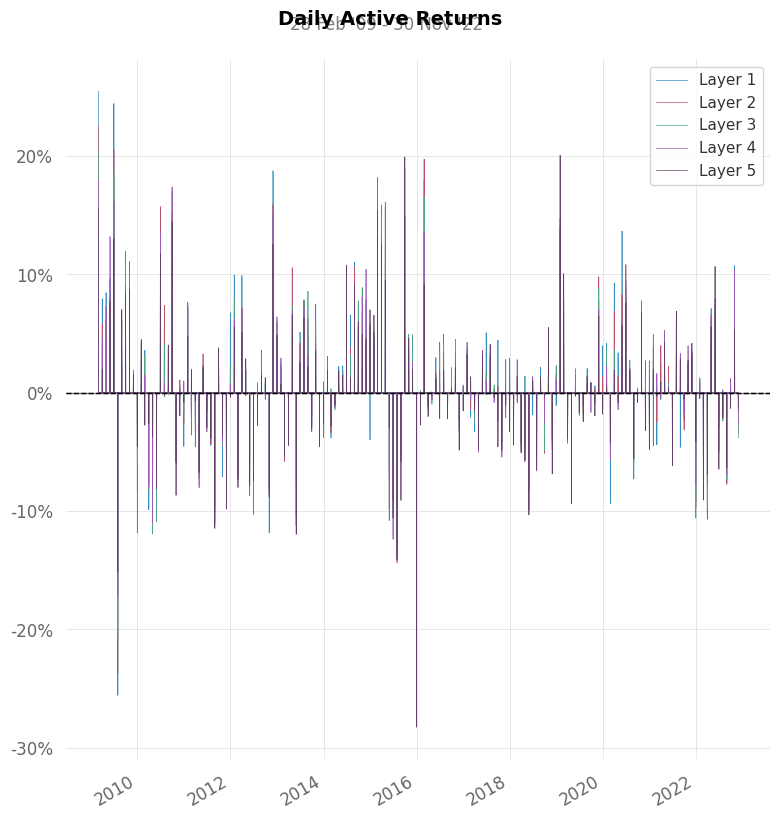

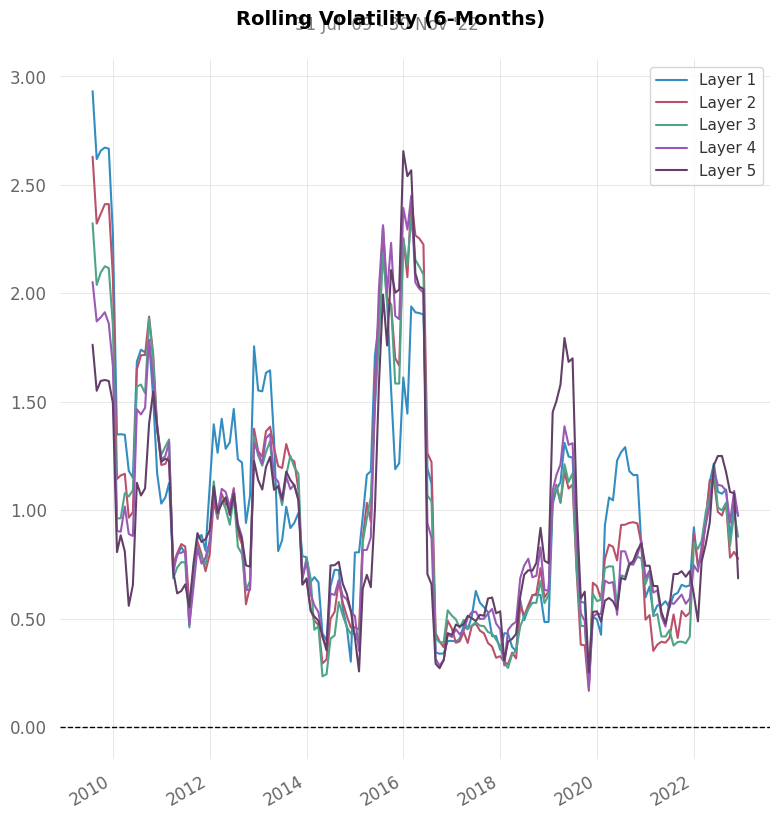

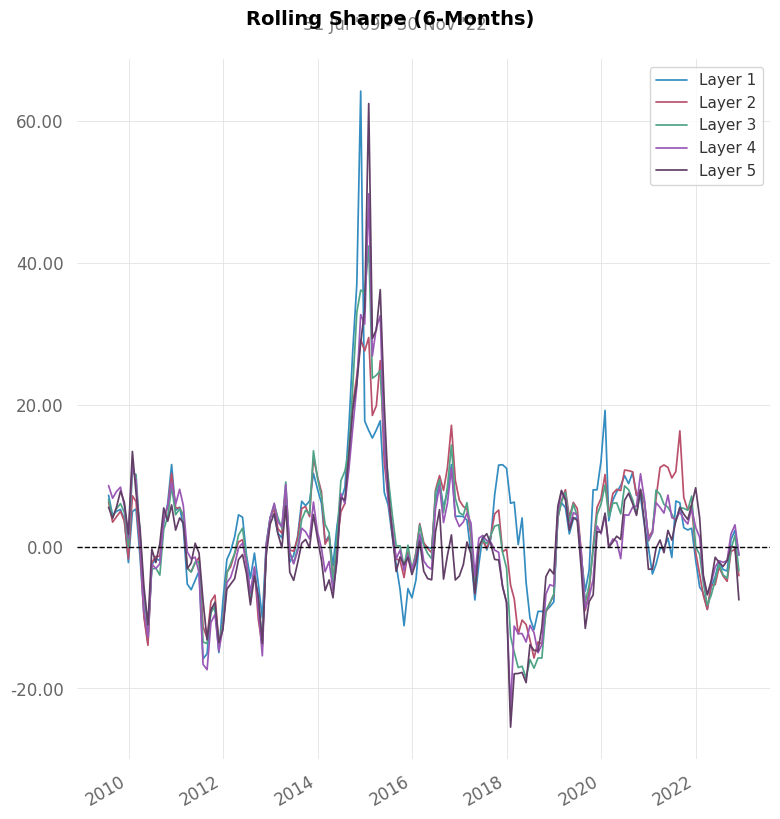

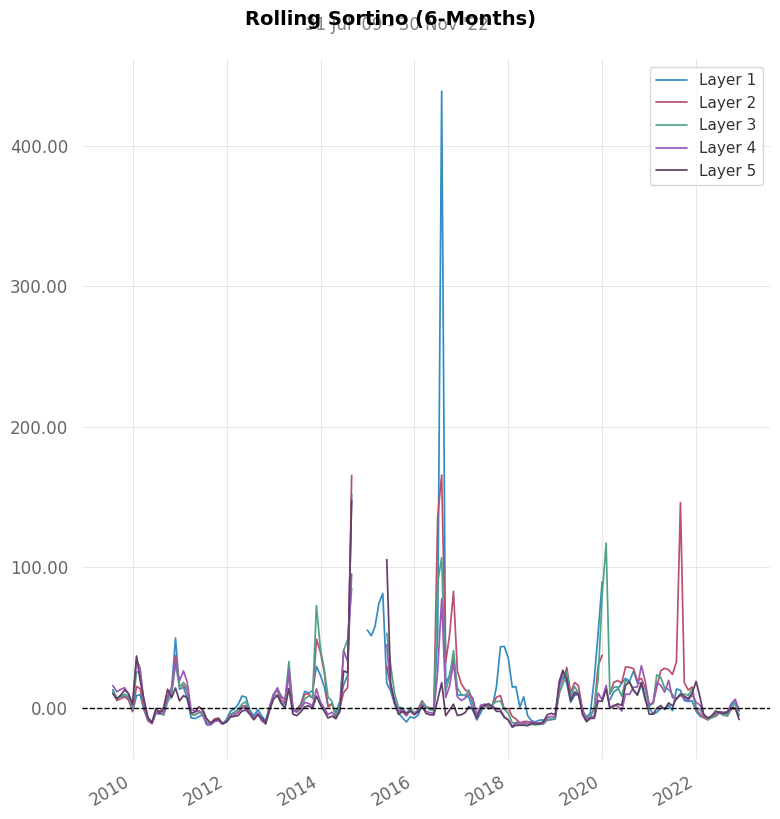

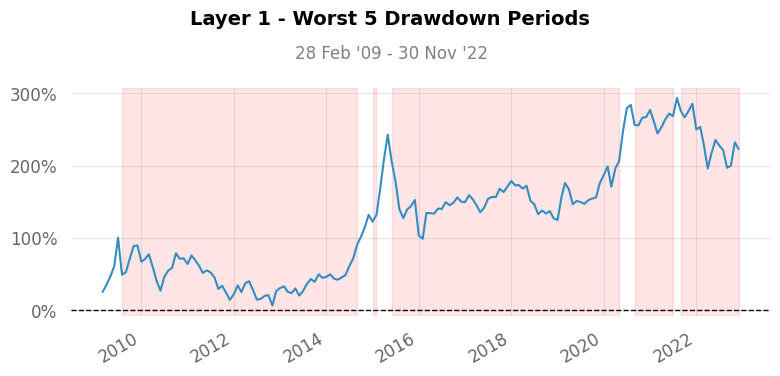

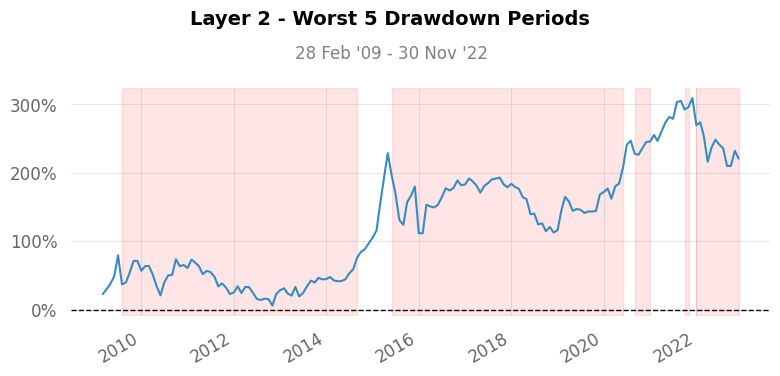

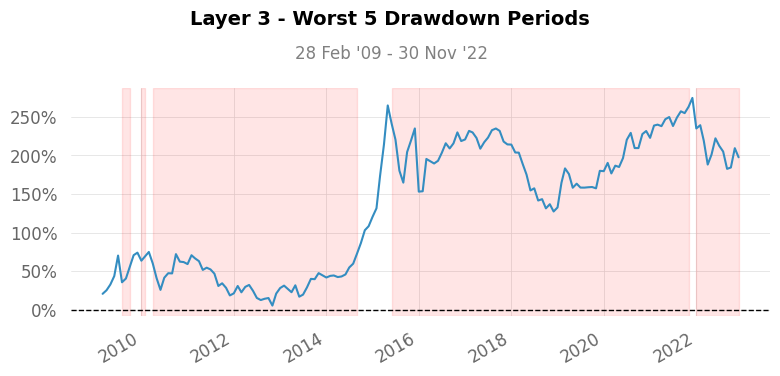

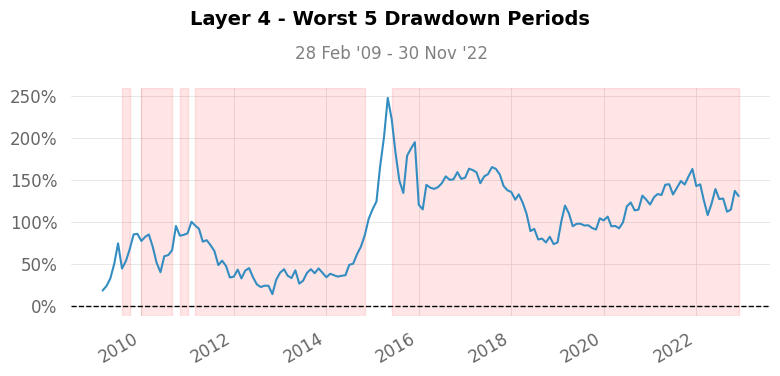

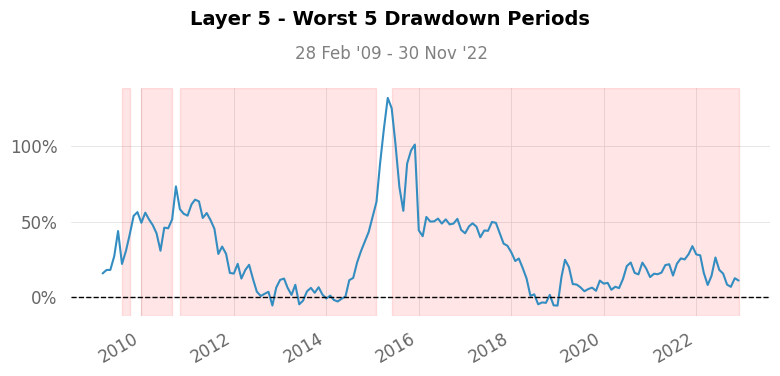

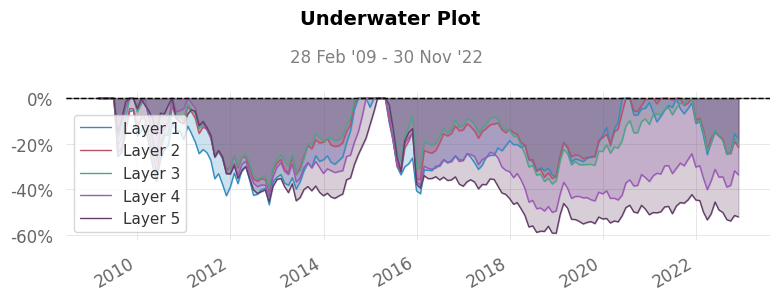

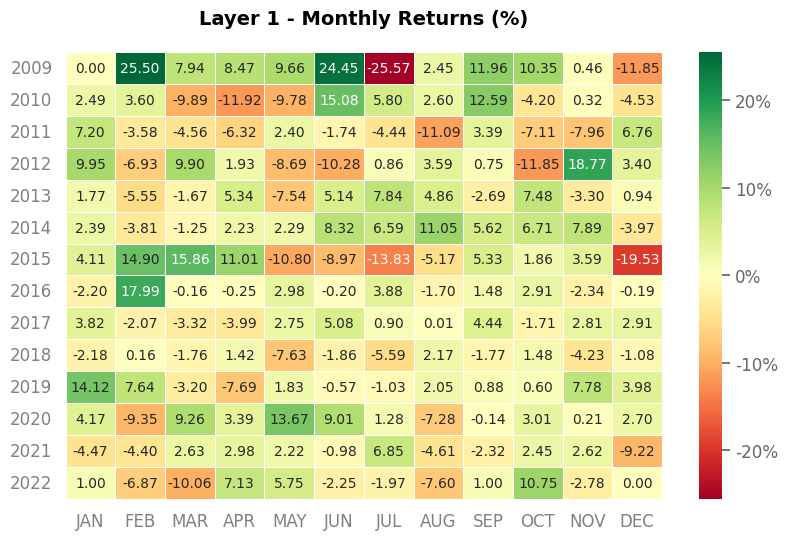

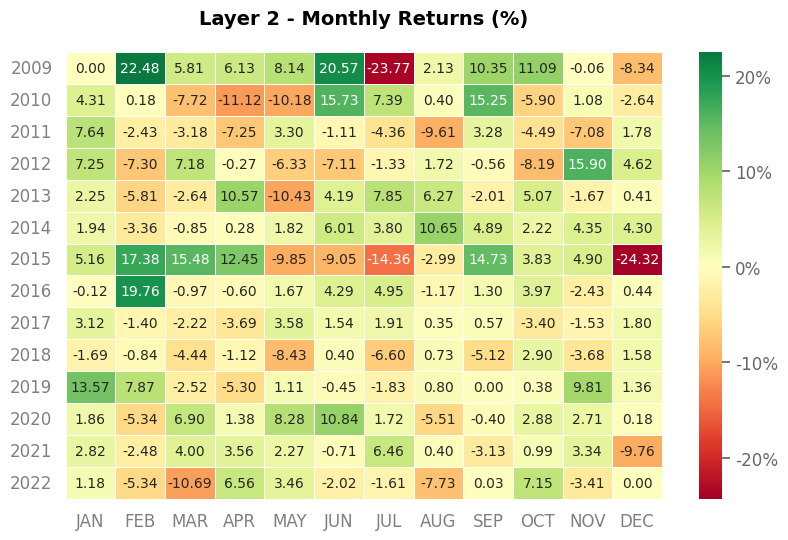

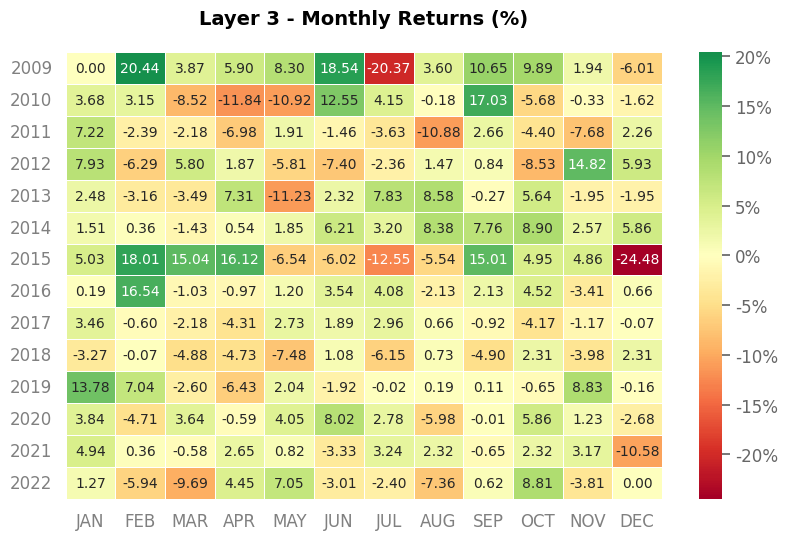

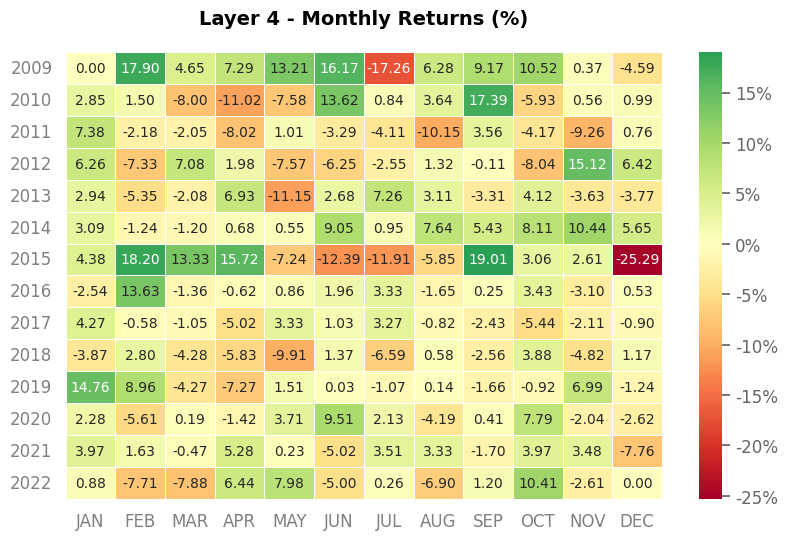

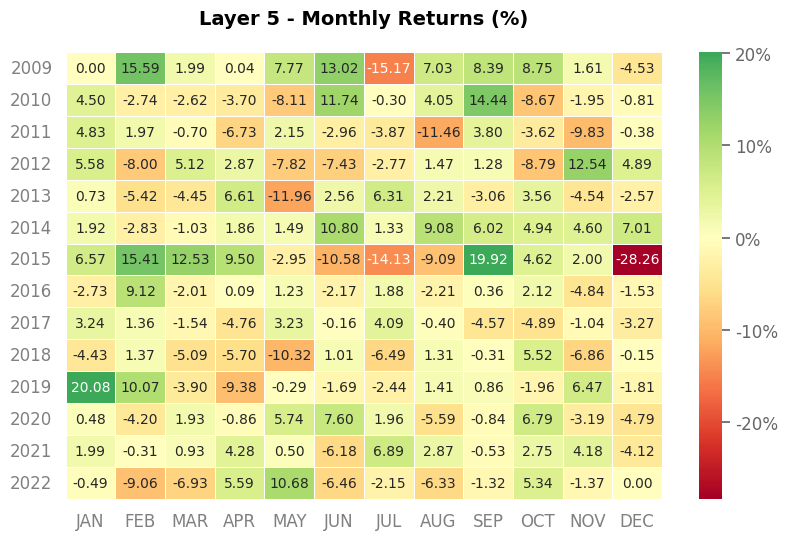

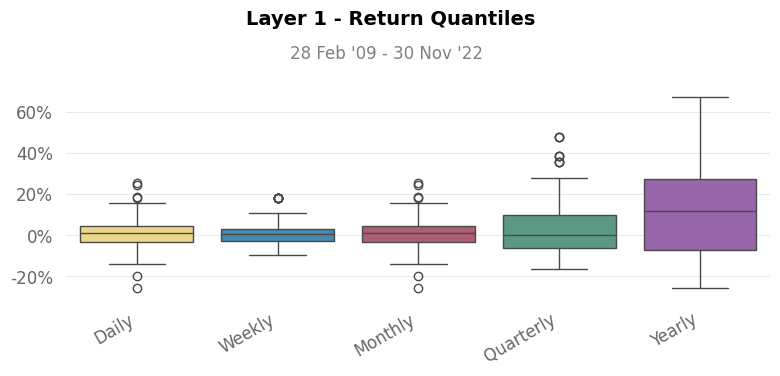

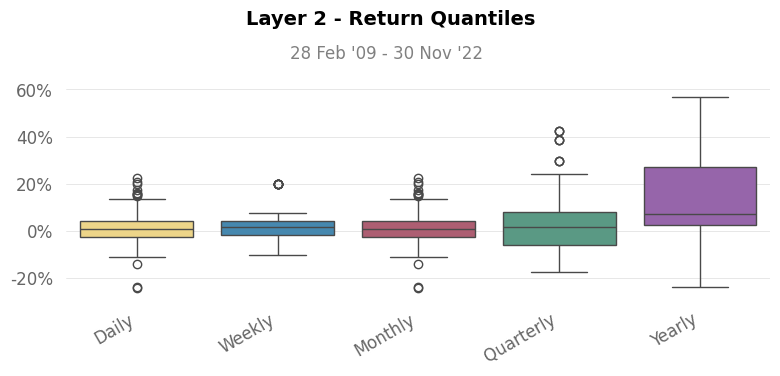

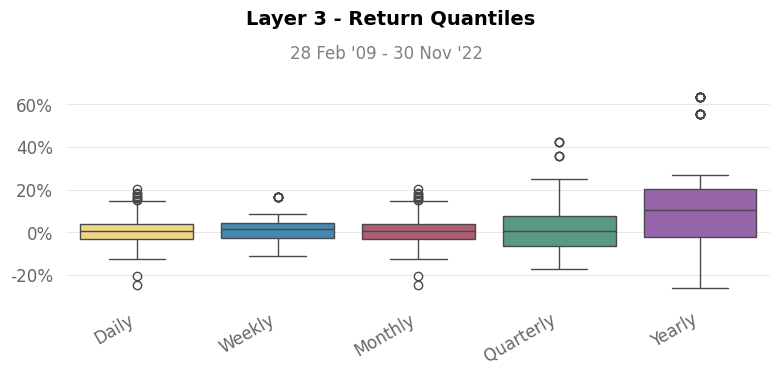

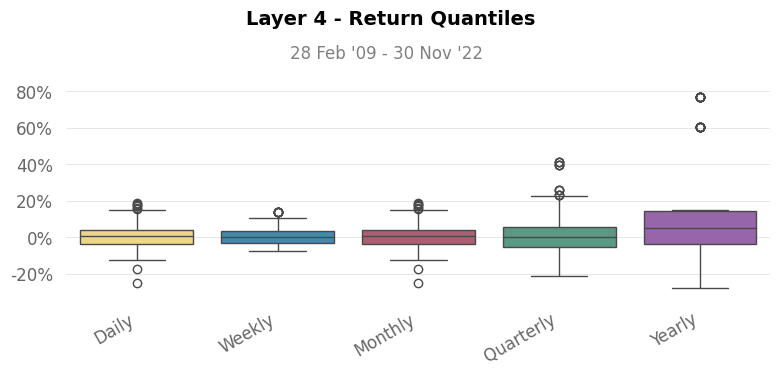

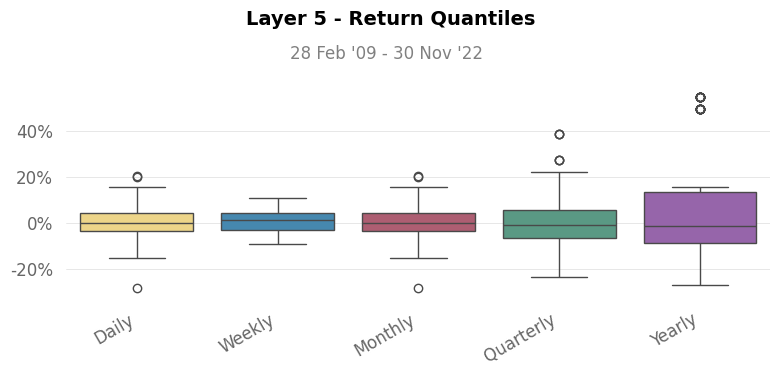

In [ ]:
copy = store_returns_12_avg.copy()
copy.reset_index(inplace = True)
dates = pd.date_range(start='2009-02-28', end='2022-11-30', freq='M')
copy.insert(0,'date',dates)
copy.drop('index',axis = 1, inplace = True)
copy.set_index('date',inplace = True)
copy.columns = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5',]

qs.reports.full(copy,periods_per_year= 12)

## Long-Short Strategy & Comparison with Benchmark Index

In [29]:
# Long Layer 1 (top 20 stocks) and Short Layer 5 (bottom 20 stocks)
strategy = pd.DataFrame(store_returns_12_t20.iloc[:,0])

In [ ]:
strategy

1
2009-02  0.272627
2009-03  0.164387
2009-04  0.106722
2009-05   0.09187
2009-06  0.313393
...           ...
2022-07 -0.043745
2022-08 -0.079262
2022-09  0.022189
2022-10  0.050376
2022-11 -0.026416

[166 rows x 1 columns]

In [30]:
strategy.columns=['top_1']

In [31]:
strategy['bottom_5'] = store_returns_12_b20.iloc[:,4]

In [ ]:
strategy

top_1  bottom_5
2009-02  0.272627  0.143755
2009-03  0.164387  0.016572
2009-04  0.106722 -0.018091
2009-05   0.09187  0.071824
2009-06  0.313393    0.1477
...           ...       ...
2022-07 -0.043745 -0.056024
2022-08 -0.079262 -0.079223
2022-09  0.022189 -0.069103
2022-10  0.050376    -0.021
2022-11 -0.026416 -0.058058

[166 rows x 2 columns]

In [32]:
strategy['strategy_ret'] = strategy['top_1'] - strategy['bottom_5']

In [33]:
strategy['strategy_cumsum'] = np.cumsum(strategy['strategy_ret'],axis = 0)

In [ ]:
strategy

top_1  bottom_5 strategy_ret strategy_cumsum
2009-02  0.272627  0.143755     0.128872        0.128872
2009-03  0.164387  0.016572     0.147815        0.276687
2009-04  0.106722 -0.018091     0.124813        0.401499
2009-05   0.09187  0.071824     0.020046        0.421545
2009-06  0.313393    0.1477     0.165693        0.587238
...           ...       ...          ...             ...
2022-07 -0.043745 -0.056024     0.012279        2.103967
2022-08 -0.079262 -0.079223    -0.000039        2.103928
2022-09  0.022189 -0.069103     0.091292        2.195219
2022-10  0.050376    -0.021     0.071377        2.266596
2022-11 -0.026416 -0.058058     0.031642        2.298238

[166 rows x 4 columns]

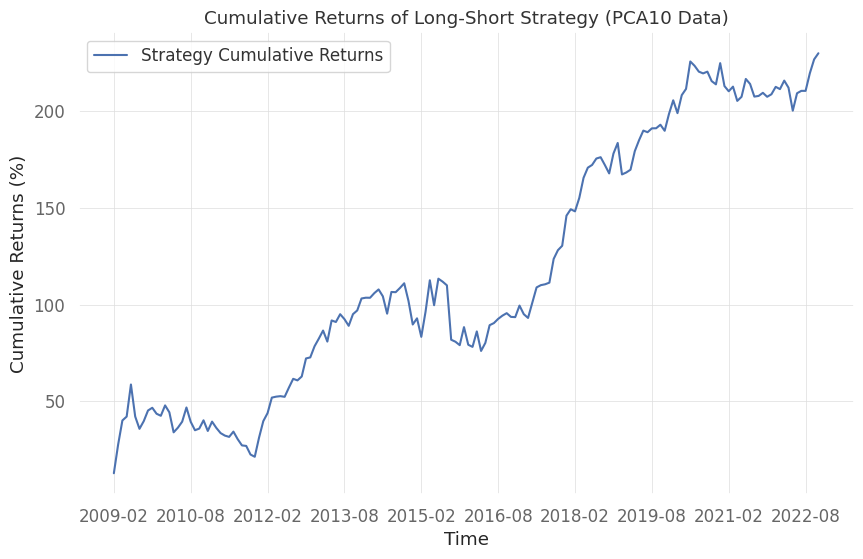

In [35]:
plt.plot(cum_index_12_avg, strategy['strategy_cumsum']*100,label='Strategy Cumulative Returns')

# Set date on x-axis
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(18))

plt.title('Cumulative Returns of Long-Short Strategy (PCA10 Data)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Import Data for Benchmark Indices

In [ ]:
indices = pd.read_csv('/content/drive/MyDrive/Optimas Code/Indices_M_2005-2023.csv')
indices

Date   CSI 300   CSI 500  FTSE A50     HSCEI
0    2005-01-31 -0.045121 -0.077347 -0.020934 -0.008807
1    2005-02-28  0.089132  0.106426  0.076313  0.091254
2    2005-03-31 -0.094026 -0.122231 -0.072592 -0.069795
3    2005-04-30 -0.010410 -0.054077  0.012353 -0.028182
4    2005-05-31 -0.081992 -0.059861 -0.107817 -0.030565
..          ...       ...       ...       ...       ...
223  2023-08-31 -0.062113 -0.057298 -0.052659 -0.082166
224  2023-09-30 -0.020118 -0.008473 -0.016183 -0.053986
225  2023-10-31 -0.031715 -0.028561 -0.032789 -0.018841
226  2023-11-30 -0.021358  0.003041 -0.019637 -0.000717
227  2023-12-31 -0.018618 -0.020887 -0.021476 -0.015201

[228 rows x 5 columns]

In [ ]:
indices_subset = indices.copy()
indices_subset = indices_subset[(indices_subset['Date'] >= '2009-02-01') & (indices_subset['Date'] <= '2022-11-30')]
indices_subset

Date   CSI 300   CSI 500  FTSE A50     HSCEI
49   2009-02-28  0.053037  0.079920  0.032015 -0.032129
50   2009-03-31  0.171596  0.205705  0.148914  0.169103
51   2009-04-30  0.045912  0.059053  0.037139  0.125745
52   2009-05-31  0.052150  0.061736  0.049690  0.122989
53   2009-06-30  0.147393  0.053564  0.194281  0.051248
..          ...       ...       ...       ...       ...
210  2022-07-31 -0.070214 -0.024785 -0.083787 -0.101919
211  2022-08-31 -0.021885 -0.021984 -0.010670 -0.002957
212  2022-09-30 -0.067165 -0.071751 -0.048976 -0.138532
213  2022-10-31 -0.077843  0.016283 -0.130369 -0.187021
214  2022-11-30  0.098137  0.060106  0.122649  0.290749

[166 rows x 5 columns]

In [ ]:
indices_cumsum = np.cumsum(indices_subset.set_index('Date'), axis=0)

In [ ]:
indices_cumsum

CSI 300   CSI 500  FTSE A50     HSCEI
Date                                              
2009-02-28  0.053037  0.079920  0.032015 -0.032129
2009-03-31  0.224633  0.285625  0.180929  0.136974
2009-04-30  0.270545  0.344678  0.218068  0.262720
2009-05-31  0.322695  0.406414  0.267759  0.385708
2009-06-30  0.470088  0.459978  0.462040  0.436956
...              ...       ...       ...       ...
2022-07-31  1.121523  1.512443  1.074196 -0.049333
2022-08-31  1.099638  1.490459  1.063525 -0.052290
2022-09-30  1.032473  1.418708  1.014549 -0.190822
2022-10-31  0.954630  1.434991  0.884180 -0.377843
2022-11-30  1.052767  1.495097  1.006829 -0.087095

[166 rows x 4 columns]

In [ ]:
# indices_cumsum.drop('long-short-comp',axis = 1, inplace = True)

### Store the cumulated indices

In [ ]:
# indices_cumsum.to_csv('indices_cumsum_2009to2022.csv')

### Calculate Alpha of Machine Learning Strategy

In [ ]:
portfolio_returns = strategy['strategy_ret'].tolist()
benchmark_returns = indices_subset['CSI 300'].tolist()

# Convert returns to numpy arrays
portfolio_returns = sm.add_constant(portfolio_returns)
benchmark_returns = sm.add_constant(benchmark_returns)

# Fit the regression model
model = sm.OLS(portfolio_returns[:,1], benchmark_returns)
result = model.fit()

# Get alpha
alpha = result.params[0]

print("Alpha:", alpha)

Alpha: 0.013300625921046817


In [ ]:
# By quantstats

# Convert index to DatetimeIndex
indices_subset['Date'] = pd.DatetimeIndex(indices_subset['Date'])

strategy_copy = strategy.copy()
strategy_copy.index = indices_subset.set_index('Date').index

In [ ]:
qs.stats.greeks(strategy_copy['strategy_ret'], indices_subset.set_index('Date')['CSI 300'], periods = 12, prepare_returns=True)

beta     0.085806
alpha    0.159608
dtype: float64

In [ ]:
# Calculate the annualized return
# (indices_subset['long-short-comp'].mean()+1)**12-1

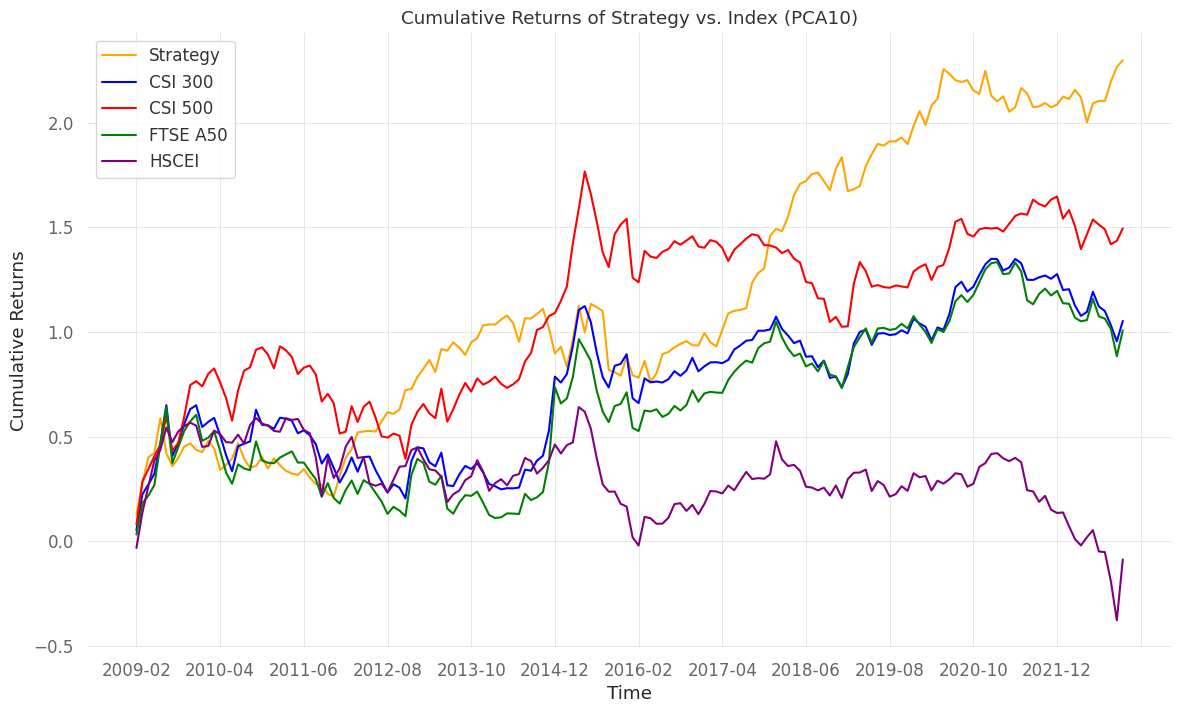

In [ ]:
# Plot the cumulative return of the strategy vs. index

plt.figure(figsize=(14, 8))

plt.plot(cum_index_12_avg, strategy['strategy_cumsum'], label='Strategy', color='orange')
plt.plot(cum_index_12_avg, indices_cumsum['CSI 300'], label='CSI 300', color='blue')
plt.plot(cum_index_12_avg, indices_cumsum['CSI 500'], label='CSI 500', color='red')
plt.plot(cum_index_12_avg, indices_cumsum['FTSE A50'], label='FTSE A50', color='green')
plt.plot(cum_index_12_avg, indices_cumsum['HSCEI'], label='HSCEI', color='purple')

# Set date on x-axis
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(14))

plt.title('Cumulative Returns of Strategy vs. Index (PCA10)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# qs.reports.html(strategy['strategy_cumsum'], "SPY")

In [ ]:
strategy['strategy_cumsum'][-1] - indices_cumsum['CSI 300'][-1]

1.2454708273308674

## Correlation Between The Two Datasets

In [36]:
ChinaA = pd.read_csv('/content/drive/MyDrive/Optimas Code/cleaned_ChinaA.csv')
ChinaA.head(3)

Unnamed: 0   SecuCode  average_asig_fsig year_month  next_month_return
0           0  000001.SZ          -1.088436    2009-02           0.125731
1           1  600185.SH           0.067302    2009-02           0.006659
2           2  000968.SZ           0.734408    2009-02           0.216531

In [37]:
ChinaA.shape

(307407, 5)

In [ ]:
ChinaA.drop('Unnamed: 0',axis = 1, inplace = True)

In [ ]:
grouped_data = ChinaA.groupby('year_month')

In [ ]:
store_returns_avg = pd.DataFrame(index=ChinaA['year_month'].unique(), columns=range(1, 6))

In [ ]:
# Take average of all stocks in each layer
for month, group in grouped_data:
    # Sort the group by predicted returns (decending)
    group_sorted = group.sort_values(by='average_asig_fsig',ascending=False)

    # Calculate number of stocks in each decile
    num_stocks = len(group_sorted)
    stocks_per_decile = num_stocks // 5

    # Initialize an empty DataFrame to store average actual returns for each decile
    avg_actual_returns = pd.DataFrame(index=range(1, 6), columns=['avg_actual_return'])

    # Loop through each decile
    for decile in range(1, 6):
        # Calculate the start and end indices for the current decile
        start_idx = (decile - 1) * stocks_per_decile
        end_idx = decile * stocks_per_decile

        # Calculate average actual return for the current decile using the top 20 stocks
        avg_actual_return = group_sorted['next_month_return'][start_idx:end_idx].mean()
        store_returns_avg.loc[month,decile] = avg_actual_return

In [ ]:
store_returns_avg

1         2         3         4         5
2009-02  0.067368  0.044478  0.029719  0.032232  0.080521
2009-03  0.022226  0.023348  0.017836  0.030077   0.03122
2009-04     0.021  0.019674  0.012182  0.017456  0.033642
2009-05  0.026473  0.018253  0.011536  0.021472  0.037987
2009-06  0.060691   0.03591  0.011308  0.049742  0.070172
...           ...       ...       ...       ...       ...
2021-12  0.016033  0.013666  0.013394  0.017563  0.021257
2022-01 -0.003266 -0.001264 -0.001464  0.000668  -0.00158
2022-02  -0.02549  -0.01599 -0.020597 -0.020843 -0.026287
2022-03  -0.00334 -0.000197  0.003508 -0.000271  0.000292
2022-04 -0.035117 -0.018295 -0.028446 -0.032452 -0.057978

[159 rows x 5 columns]

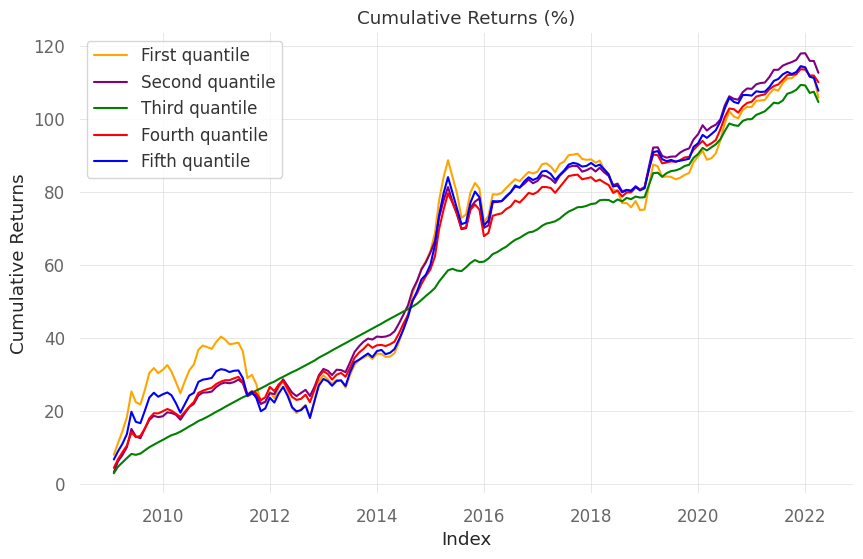

In [ ]:
dates2 = pd.to_datetime([date for date in store_returns_avg.index.unique()])
# Calculate the cumulative sum
cumulative_values = np.cumsum(store_returns_avg[1])
cumulative_values2 = np.cumsum(store_returns_avg[2])
cumulative_values3 = np.cumsum(store_returns_avg[3])
cumulative_values4 = np.cumsum(store_returns_avg[4])
cumulative_values5 = np.cumsum(store_returns_avg[5])

# Plot the cumulative values
plt.figure(figsize=(10, 6))
plt.plot(dates2, cumulative_values5*100, color='orange', label='First quantile')
plt.plot(dates2, cumulative_values4*100, color='purple', label='Second quantile')
plt.plot(dates2, cumulative_values3*100, color='green', label='Third quantile')
plt.plot(dates2, cumulative_values2*100, color='red', label='Fourth quantile')
plt.plot(dates2, cumulative_values*100, color='blue', label='Fifth quantile')



plt.title('Cumulative Returns (%)')
plt.xlabel('Index')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Top 20 stocks of each layer
store_returns_t20 = pd.DataFrame(index=ChinaA['year_month'].unique(), columns=range(1, 3))

In [ ]:

for month, group in grouped_data:
    # Sort the group by predicted returns (decending)
    group_sorted = group.sort_values(by='average_asig_fsig',ascending=False)

    # Calculate number of stocks in each decile
    num_stocks = len(group_sorted)
    stocks_per_decile = num_stocks // 5

    # Initialize an empty DataFrame to store average actual returns for each decile
    avg_actual_returns = pd.DataFrame(index=range(1, 6), columns=['avg_actual_return'])

    # Loop through each decile
    for decile in range(1, 6):
        # Calculate the start and end indices for the current decile
        start_idx = (decile - 1) * stocks_per_decile
        end_idx = decile * stocks_per_decile

        # Select only the top 20 stocks within the current decile
        decile_top_20 = group_sorted.iloc[start_idx:end_idx]
        if len(decile_top_20) > 20:
            decile_top_20 = decile_top_20.head(20)

        # Calculate average actual return for the current decile using the top 20 stocks
        avg_actual_return = decile_top_20['next_month_return'].mean()
        store_returns_t20.loc[month,decile] = avg_actual_return

In [ ]:
store_returns_t20

1         2         3         4         5
2009-02   0.05389  0.018451  0.049513  0.039996  0.028906
2009-03  0.032003   0.05194  0.047285  0.027014  0.028581
2009-04  0.021291  0.028961  0.024329  0.006659  0.033917
2009-05  0.042143  0.014196  0.014523  0.013188  0.023720
2009-06  0.117131   0.01868  0.026335  0.031542  0.048907
...           ...       ...       ...       ...       ...
2021-12  0.015023 -0.026949 -0.000362  0.014355 -0.001460
2022-01  -0.05128 -0.009055  0.038484  0.024835  0.003713
2022-02 -0.037999 -0.029827 -0.019223 -0.009914 -0.036591
2022-03 -0.048613  0.016977 -0.008591 -0.001183 -0.004794
2022-04  -0.06831 -0.010955 -0.012097 -0.051892 -0.092835

[159 rows x 5 columns]

In [ ]:
store_returns_strategy = pd.DataFrame(store_returns_t20.iloc[:,0])

In [ ]:
store_returns_strategy.columns = ['top_1']

In [ ]:
indices_subset = indices_subset.set_index('Date')
CSI_300_df = indices_subset['CSI 300'].copy()
CSI_300_df.index = pd.to_datetime(CSI_300_df.index)
#CSI_300_df = CSI_300_df.set_index(Date)

# Format the index to year-month string and set as new index
CSI_300_df.index = CSI_300_df.index.strftime('%Y-%m')

In [ ]:
CSI_300_df = pd.DataFrame(CSI_300_df)
CSI_300_df

CSI 300
Date             
2009-02  0.053037
2009-03  0.171596
2009-04  0.045912
2009-05  0.052150
2009-06  0.147393
...           ...
2022-07 -0.070214
2022-08 -0.021885
2022-09 -0.067165
2022-10 -0.077843
2022-11  0.098137

[166 rows x 1 columns]

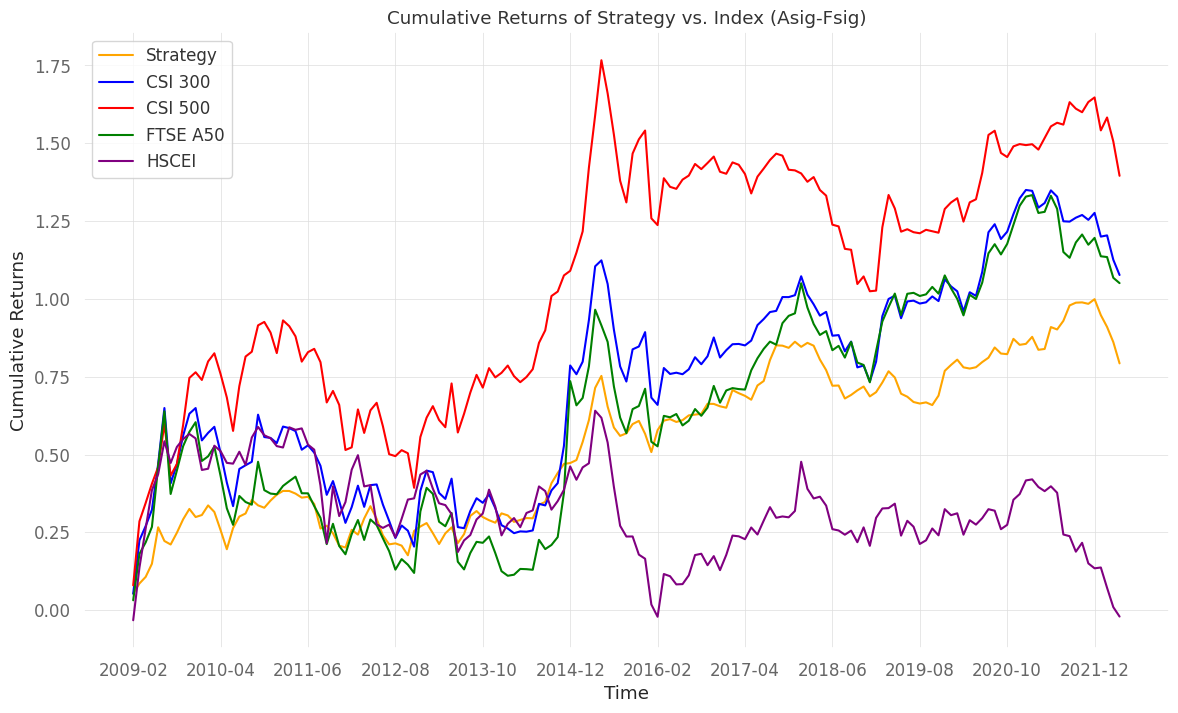

In [ ]:
#indices_subset = indices_subset.set_index('Date')
#indices_subset.index = pd.to_datetime(indices_subset)


strategy_ret_df = store_returns_strategy.copy()
#strategy_ret_df.index = pd.to_datetime(strategy_ret_df.index + "-01").to_period('M').to_timestamp('M')
strategy_ret_df['strategy ret'] = store_returns_strategy['top_1'] - CSI_300_df['CSI 300']


cum_returns_avg = np.cumsum(store_returns_avg, axis=0)
# Convert index to string
cum_index_avg = cum_returns_avg.index.to_series().astype(str)

# Plot the cumulative return of the strategy vs. index

plt.figure(figsize=(14, 8))

plt.plot(cum_index_avg, np.cumsum(strategy_ret_df['top_1'],axis = 0), label='Strategy', color='orange')
plt.plot(cum_index_avg, indices_cumsum['CSI 300'].loc[:'2022-04-30'], label='CSI 300', color='blue')
plt.plot(cum_index_avg, indices_cumsum['CSI 500'].loc[:'2022-04-30'], label='CSI 500', color='red')
plt.plot(cum_index_avg, indices_cumsum['FTSE A50'].loc[:'2022-04-30'], label='FTSE A50', color='green')
plt.plot(cum_index_avg, indices_cumsum['HSCEI'].loc[:'2022-04-30'], label='HSCEI', color='purple')

# Set date on x-axis
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(14))

plt.title('Cumulative Returns of Strategy vs. Index (Asig-Fsig)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
strategy_ret_df

top_1 strategy ret
2009-02   0.05389     0.000854
2009-03  0.032003    -0.139593
2009-04  0.021291     -0.02462
2009-05  0.042143    -0.010007
2009-06  0.117131    -0.030262
...           ...          ...
2021-12  0.015023      -0.0074
2022-01  -0.05128     0.024949
2022-02 -0.037999    -0.041915
2022-03 -0.048613     0.029754
2022-04  -0.06831     -0.01944

[159 rows x 2 columns]

### Alpha of asig_fsig strategy

In [ ]:
indices_subset2 = indices_subset[(indices_subset.index >= '2009-02-01') & (indices_subset.index <= '2022-04-30')]
indices_subset2

CSI 300   CSI 500  FTSE A50     HSCEI
Date                                              
2009-02-28  0.053037  0.079920  0.032015 -0.032129
2009-03-31  0.171596  0.205705  0.148914  0.169103
2009-04-30  0.045912  0.059053  0.037139  0.125745
2009-05-31  0.052150  0.061736  0.049690  0.122989
2009-06-30  0.147393  0.053564  0.194281  0.051248
...              ...       ...       ...       ...
2021-12-31  0.022423  0.014704  0.022032 -0.015790
2022-01-31 -0.076229 -0.105834 -0.059130  0.002629
2022-02-28  0.003917  0.041452 -0.002469 -0.065286
2022-03-31 -0.078367 -0.077094 -0.066702 -0.062069
2022-04-30 -0.048869 -0.110208 -0.017038 -0.030189

[159 rows x 4 columns]

In [ ]:
# By hand

# Alpha
portfolio_returns = store_returns_strategy['strategy ret'].tolist()
benchmark_returns = indices_subset2['CSI 300'].tolist()

# Convert returns to numpy arrays
portfolio_returns = sm.add_constant(portfolio_returns)
benchmark_returns = sm.add_constant(benchmark_returns)

# Fit the regression model
model = sm.OLS(portfolio_returns[:,1], benchmark_returns)
result = model.fit()

# Get alpha
alpha = result.params[0]

print("Alpha:", alpha)

Alpha: -0.0016779128448803564


In [ ]:
# By quantstats
# Convert index to DatetimeIndex format
#indices_subset2['Date'] = pd.DatetimeIndex(indices_subset2['Date'])

strategy_copy = strategy_ret_df.copy() #store_returns_strategy.copy()
strategy_copy.index = indices_subset2.index

In [ ]:
strategy_copy.index = pd.to_datetime(strategy_copy.index)
CSI_300_df.index = pd.to_datetime(CSI_300_df.index)
indices_subset2.index = pd.to_datetime(indices_subset2.index)
qs.stats.greeks(strategy_copy['top_1'], indices_subset2['CSI 300'], periods = 12)

beta     0.236810
alpha    0.040603
dtype: float64

## QS Reports- Strategies vs Benchmark (CSI 300)

[Performance Metrics]



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2009-03-31   2009-03-31
End Period                 2022-04-30   2022-04-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.15%       89.19%
CAGR﹪                     2.62%        3.42%

Sharpe                     0.27         0.45
Prob. Sharpe Ratio         84.02%       95.05%
Smart Sharpe               0.21         0.35
Sortino                    0.42         0.72
Smart Sortino              0.33         0.56
Sortino/√2                 0.3          0.51
Smart Sortino/√2           0.23         0.4
Omega                      1.41         1.41

Max Drawdown               -42.71%      -22.57%
Longest DD Days            2011         1250
Volatility (ann.)          24.12%       12.41%
R^2                        0.29         0.29
Information Ratio          -0.01        -0.01
Calmar             

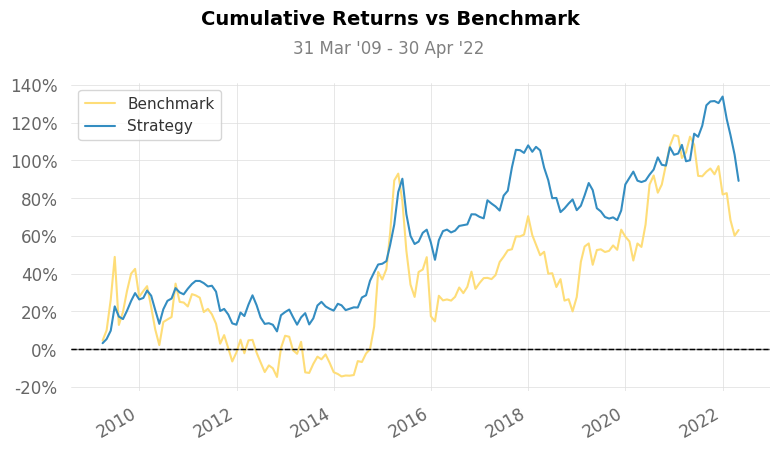

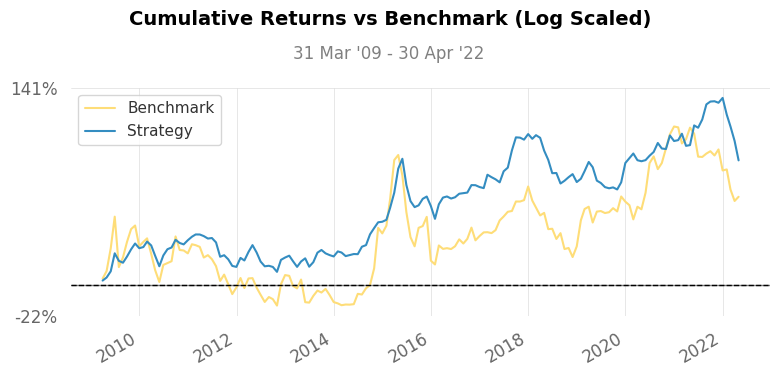

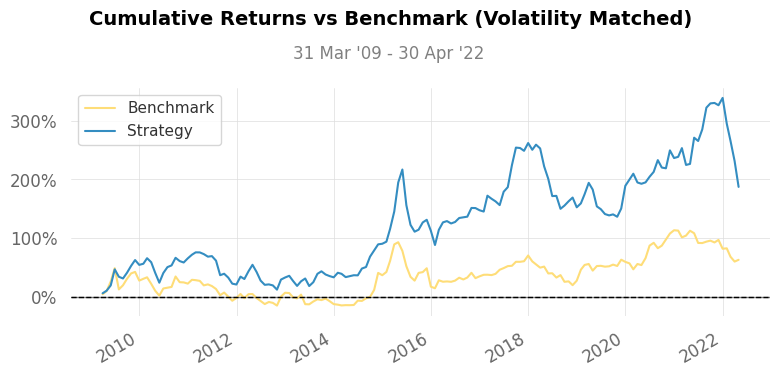

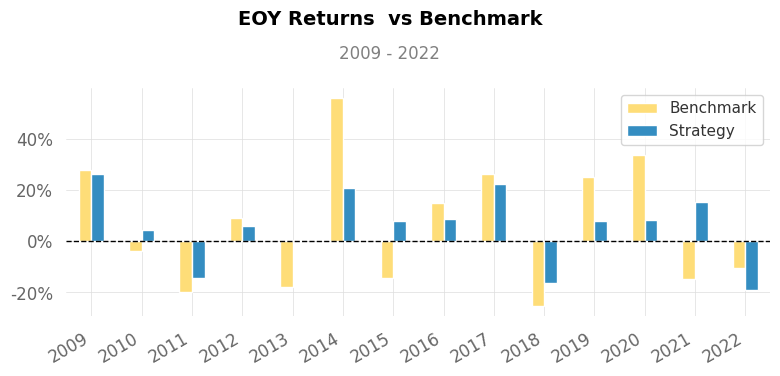

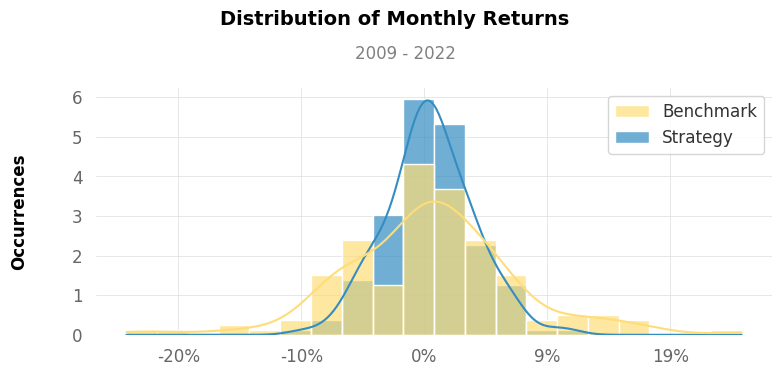

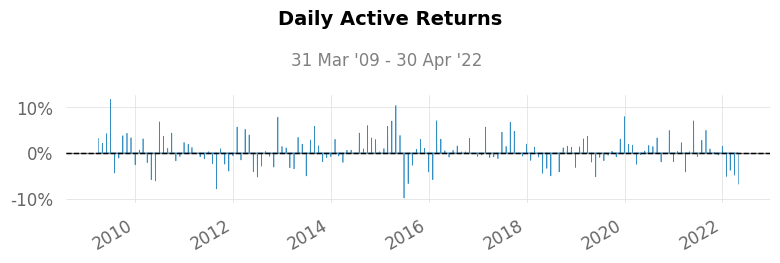

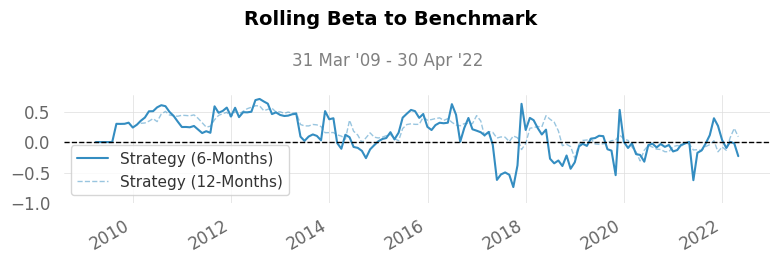

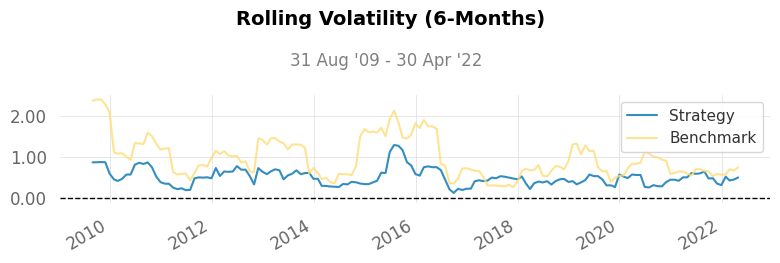

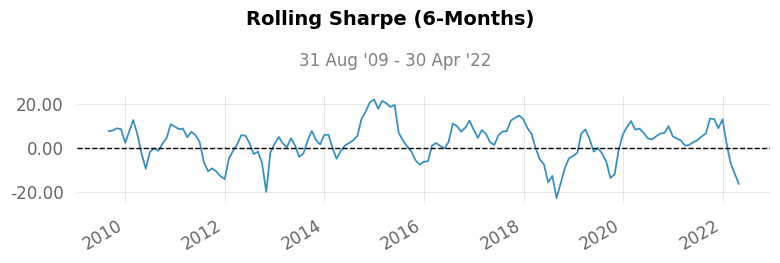

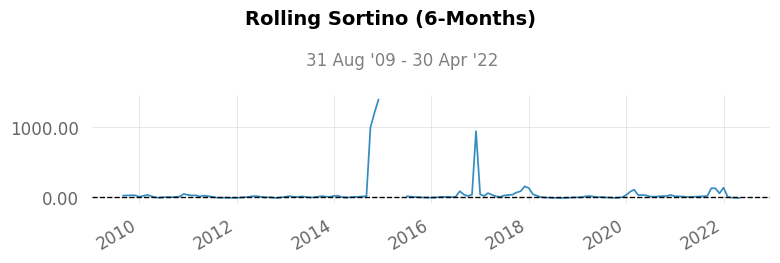

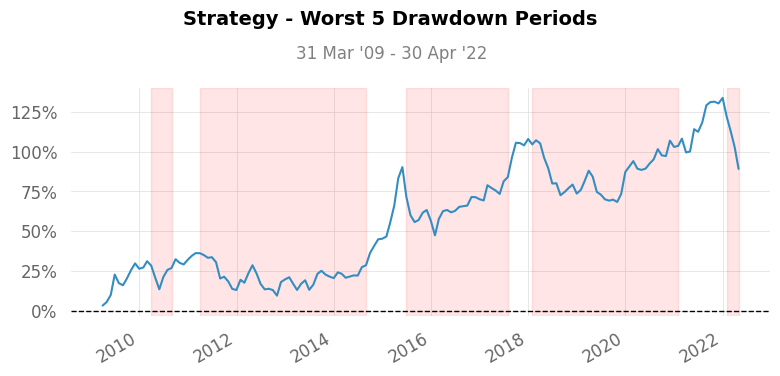

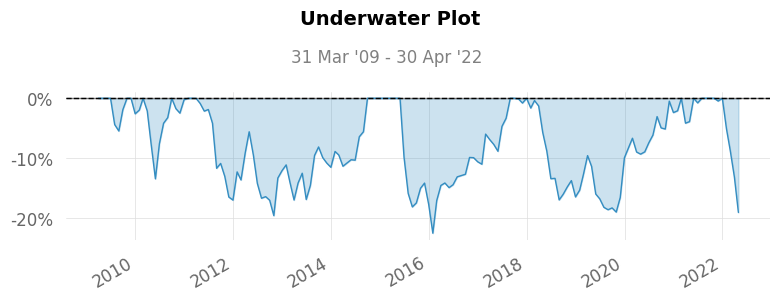

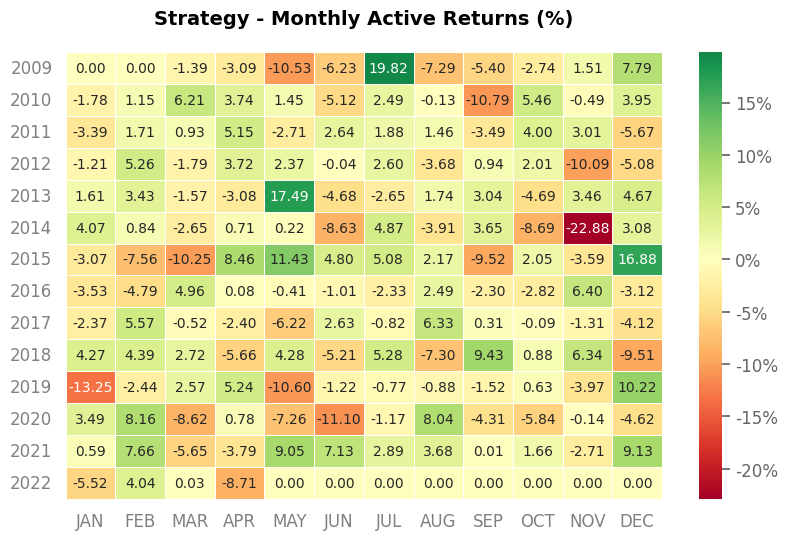

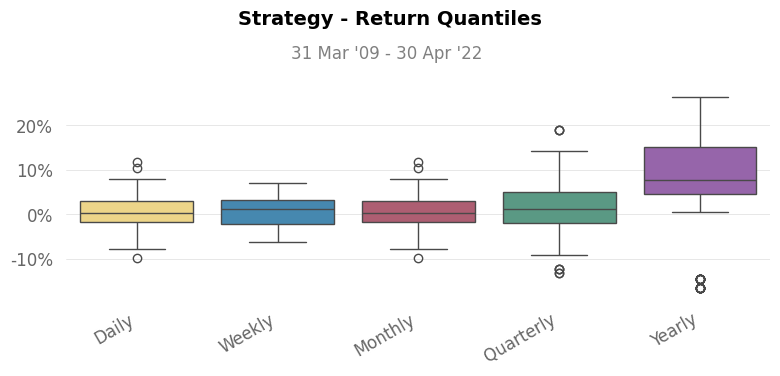

In [ ]:
## asig-fsig Long Strategy

strategy_copy.index = pd.to_datetime(strategy_copy.index)
CSI_300_df.index = pd.to_datetime(CSI_300_df.index)
qs.reports.full(strategy_copy['top_1'],periods_per_year=12, benchmark=CSI_300_df['CSI 300'])

In [ ]:
## PCA 10 Data Long-Short Strategy

strategy_df = strategy['strategy_ret'].loc[strategy.index <='2022-04']
strategy_df = pd.DataFrame(strategy_df)

[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2009-02-01   2009-02-01
End Period                 2022-11-01   2022-11-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          89.55%       573.15%
CAGR﹪                     3.26%        10.04%

Sharpe                     0.31         0.71
Prob. Sharpe Ratio         87.65%       99.37%
Smart Sharpe               0.3          0.69
Sortino                    0.48         1.12
Smart Sortino              0.47         1.08
Sortino/√2                 0.34         0.79
Smart Sortino/√2           0.33         0.77
Omega                      1.74         1.74

Max Drawdown               -42.71%      -37.57%
Longest DD Days            2011         1189
Volatility (ann.)          24.51%       23.28%
R^2                        0.01         0.01
Information Ratio          0.08        

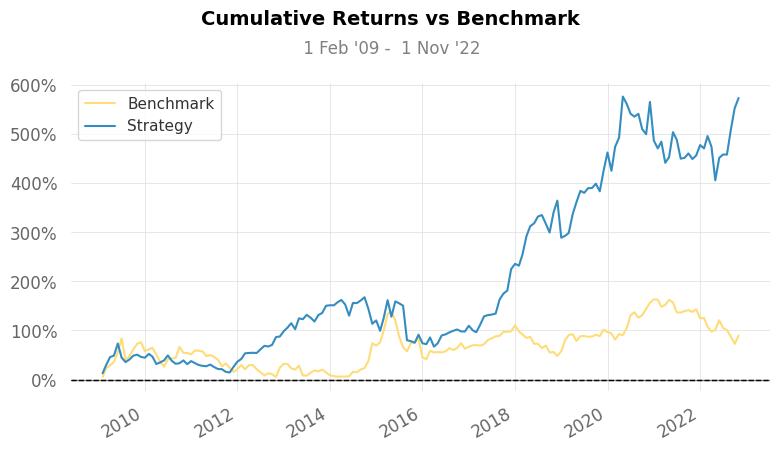

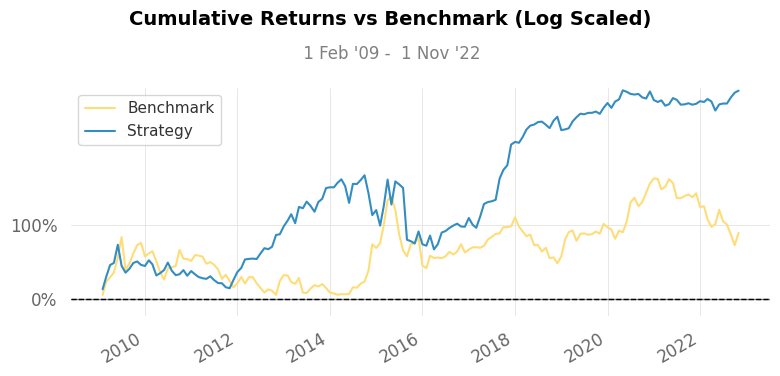

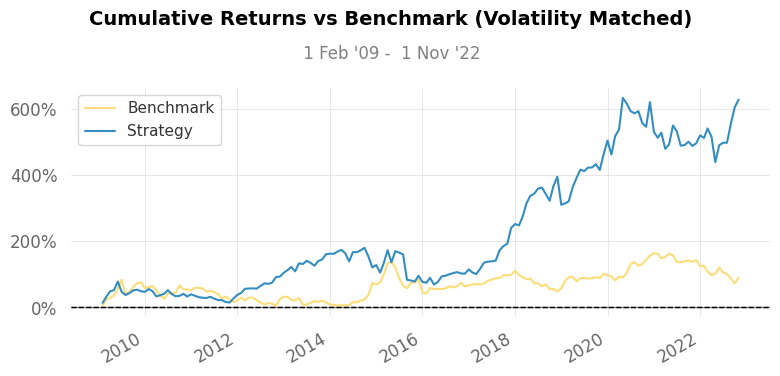

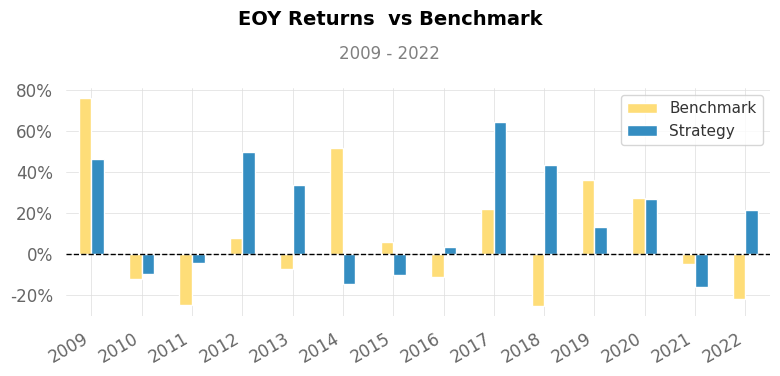

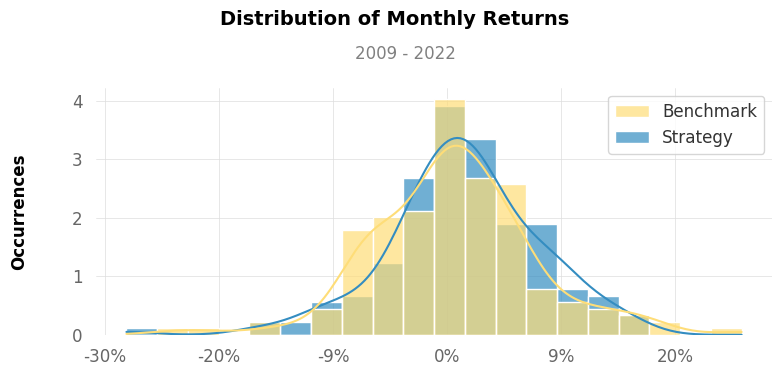

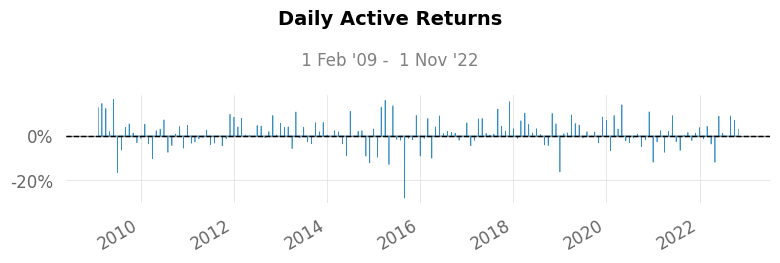

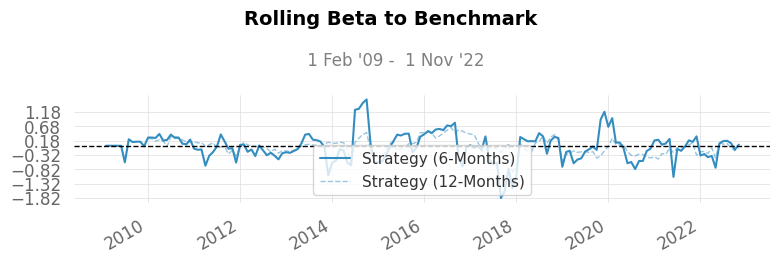

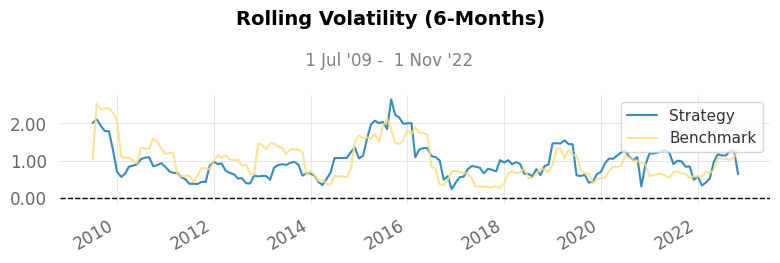

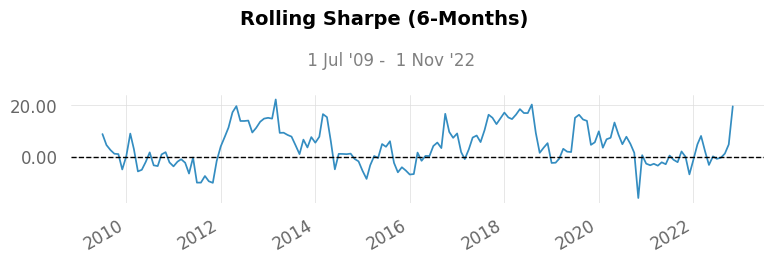

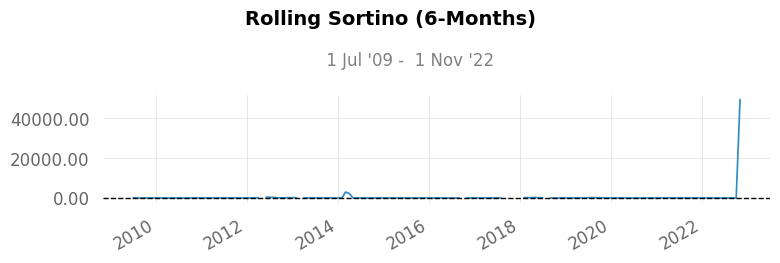

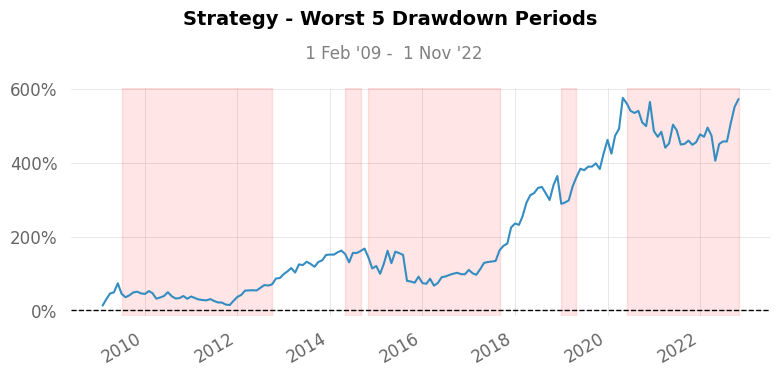

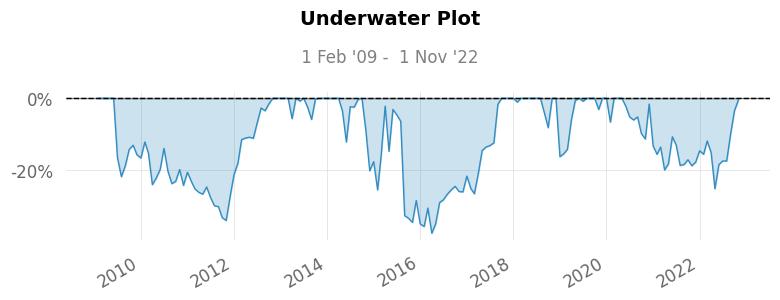

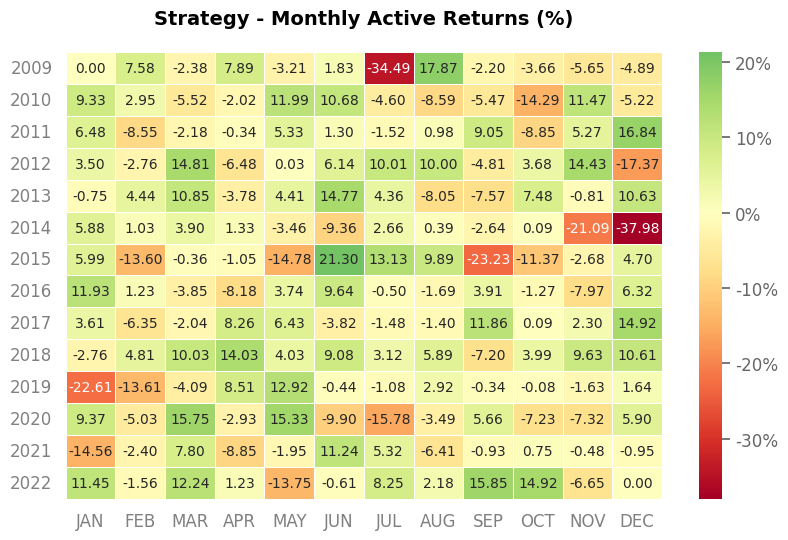

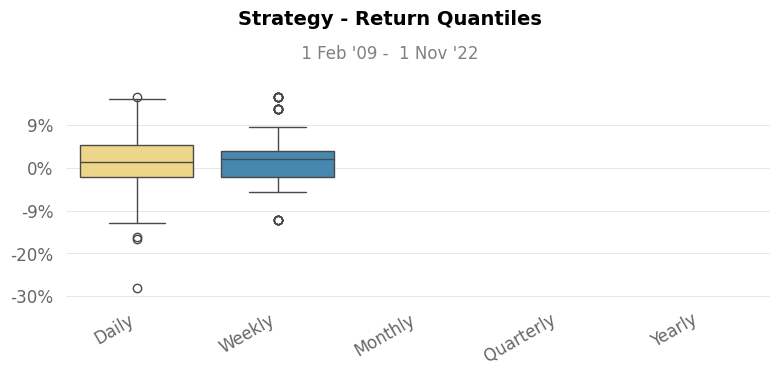

In [ ]:
#strategy_df.index = strategy_df.index.to_timestamp()
#strategy_df.index = pd.to_datetime(strategy_df.index)
strategy.index = strategy.index.to_timestamp()
strategy.index = pd.to_datetime(strategy.index)
CSI_300_df.index = pd.to_datetime(CSI_300_df.index)

#qs.reports.full(strategy_df['strategy_ret'], periods_per_year=12, benchmark=CSI_300_df)
qs.reports.full(strategy['strategy_ret'], periods_per_year=12, benchmark=CSI_300_df)

In [ ]:
#qs.reports.full(strategy_copy['strategy ret'],periods_per_year=12, benchmark=CSI_300_df['CSI 300'])

### Calculate correlation coef

In [ ]:

# Calculate correlation coef
correlation_coefficient = np.corrcoef(strategy['strategy_ret'].loc[:'2022-04-30'].tolist(), strategy_copy['strategy ret'].tolist())[0,1]

print("Pearson's correlation coefficient:", correlation_coefficient)

Pearson's correlation coefficient: -0.03612950088544655
